In [1]:
import caiman as cm
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
import tifffile as tif
from caiman.source_extraction.cnmf.cnmf import load_CNMF
from caiman.base.rois import register_multisession

import pandas as pd

import bokeh.plotting as bpl
bpl.output_notebook()

Loading BokehJS ...

In [2]:
import re
def parse_rec_name(rec_name):
    base_rec_name = os.path.basename(rec_name)
    p_mpa = re.compile('[0-9]*MPA', re.IGNORECASE)
    mpa_tag = float('.' + p_mpa.findall(base_rec_name)[0][:-3])*10
    p_dc = re.compile('[0-9]*DC', re.IGNORECASE)
    dc_tag = float('.' + p_dc.findall(base_rec_name)[0][:-2])
    return (mpa_tag, dc_tag)






class Struct():
    def __init__(self):
        return

In [22]:
# construct data dict object keyed on groups
for i,grpname in enumerate(groups):
    ref_img = tif.imread(ref_files[i])
    #sort by video number
    group_fnames = sorted(list(glob.glob(os.path.join(group_filedirs[i], out_pattern))), key = lambda x: int(x.split('-')[-1].split('_')[0]))
    
    tmpstruct = Struct()
    tmpstruct.ref_img = ref_img
    tmpstruct.cnmf_list = []
    tmpstruct.name_list = group_fnames
    tmpstruct.mpa_list = [parse_rec_name(x)[0] for x in group_fnames]
    tmpstruct.dc_list = [parse_rec_name(x)[1] for x in group_fnames]
    
    #for k, out_name in enumerate(tmpstruct.name_list):
    #    tmpstruct.cnmf_list += [load_CNMF(group_fnames[k])]
        
    data_dict[grpname] = tmpstruct
    
    

# file structure


dims = (256,256)

group_num = 1

# base_dir = '/gpfs/data/shohamlab/shared_data/yi_recordings/yi_new_holder_results/line3/new_experiments_201911/11132019/mouse9'
# groups = ['region1', 'region2']
# group_filedirs = ['region1', 'region2']
# out_pattern = "*_mc"
# ref_files = ['region1/ref.tif', 'region2/ref.tif']

# base_dir = '/gpfs/data/shohamlab/shared_data/yi_recordings/yi_new_holder_results/sst'
# groups=['mouse7', 'mouse8']
# group_filedirs = ['mouse7_single', 'mouse8_single']
# out_pattern = "*_mc.tif"
# ref_files = ['mouse7_single/ref.tif', 'mouse8_single/ref.tif']

#base_dir = '/gpfs/data/shohamlab/shared_data/yi_recordings/yi_new_holder_results/line3/new_experiments_201911/11082019/mouse6/'
base_dir = 
groups = ['region1', 'region2']
group_filedirs = ['region1', 'region2']
out_pattern = "*_mc"
ref_files = ['region1/ref.tif', 'region2/ref.tif']


data_dict = {}
os.chdir(base_dir)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\bnste\\Documents\\scripts\\script_repo\\region1\\ref.tif'

In [2]:
group_name = groups[group_num]
group_data = data_dict[group_name]
group_dir = group_filedirs[group_num]

plt.figure(figsize=(5,5))
plt.title(group_name)
plt.imshow(group_data.ref_img)
plt.show()

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/gpfs/data/shohamlab/shared_data/yi_recordings/yi_new_holder_results/line3/new_experiments_201911/11082019/mouse6/'

In [ ]:
group_data.name_list


In [ ]:
A_union, assignments, matchings = register_multisession([x.estimates.A[:,:] for x in group_data.cnmf_list], dims, templates = group_data.ref_img
                                                       )

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(A_union.sum(axis=-1).reshape(256,256, order='F'))
plt.title('Sum of {} union components'.format(A_union.shape[-1]))
plt.show()

In [ ]:
group_data.name_list[-1]

In [ ]:
movnum = -1
cellnum = 160
trial_start_offset = 110
trial_length = 100
stim_frame = 9

A = group_data.cnmf_list[movnum].estimates.A
b = group_data.cnmf_list[movnum].estimates.b
C = group_data.cnmf_list[movnum].estimates.C
f = group_data.cnmf_list[movnum].estimates.f

nframes = C.shape[1]
ntrials = (nframes - trial_start_offset)//trial_length
ncomps = C.shape[0]

svec = group_data.cnmf_list[movnum].estimates.S
svec = svec[:,trial_start_offset:trial_start_offset + trial_length*ntrials]
dffvec = group_data.cnmf_list[movnum].estimates.F_dff
dffvec = dffvec[:,trial_start_offset:trial_start_offset + trial_length*ntrials]
fvec = group_data.cnmf_list[movnum].estimates.C
fvec = fvec[:,trial_start_offset:trial_start_offset + trial_length*ntrials]
bg_contrib = A.T.dot(b).dot(f) # background contribution to visible fluorescence in ROIs
bg_contrib = bg_contrib[:,trial_start_offset:trial_start_offset + trial_length*ntrials]




trial_avg_svec = np.reshape(svec,(ncomps,ntrials,trial_length), order='C').mean(axis=1)
trial_avg_dffvec = np.reshape(dffvec,(ncomps,ntrials,trial_length), order='C').mean(axis=1)
trial_avg_fvec = np.reshape(fvec,(ncomps,ntrials,trial_length), order='C').mean(axis=1)
trial_avg_bg = f[:,trial_start_offset:trial_start_offset + trial_length*ntrials].reshape((-1,ntrials,trial_length), order='C').mean(axis=1)

# calculate "simplistic" DF/F traces per trial block - use time period leading up to stim
tmp_f = fvec + bg_contrib # include background component in baseline calculation
tmp_f = tmp_f.reshape((ncomps,ntrials,trial_length), order='C')
tmp_f_baseline = tmp_f[:,:,:stim_frame].mean(axis=-1, keepdims = True)
trial_avg_simple_dff = ((tmp_f - tmp_f_baseline) / tmp_f_baseline).mean(axis=1)


plt.figure(figsize=(8,16))
plt.subplot(4,1,1)
plt.title('Component fluorescence trial average: cell {}'.format(cellnum))
plt.plot(trial_avg_fvec[cellnum])
plt.subplot(4,1,2)
plt.title('"Spiking" deconvolution trial average: cell {}'.format(cellnum))
plt.plot(trial_avg_svec[cellnum])
plt.subplot(4,1,3)
plt.title('caiman DF/F trial average: cell {}'.format(cellnum))
plt.plot(trial_avg_dffvec[cellnum])
plt.subplot(4,1,4)
plt.title('"simple" DF/F trial average: cell {}'.format(cellnum))
plt.plot(trial_avg_simple_dff[cellnum])


plt.show()

In [ ]:

plt.figure(figsize=(12,10))
plt.subplot(1,3,1)

ax = plt.imshow(trial_avg_svec)
plt.title('spiking trial average')
ax.axes.axvline(x=stim_frame, color='red', linewidth=.4)

plt.subplot(1,3,2)

ax = plt.imshow(trial_avg_dffvec)
plt.title('caiman DF/F trial average')
ax.axes.axvline(x=stim_frame, color='red', linewidth=.4)

plt.subplot(1,3,3)

ax = plt.imshow(trial_avg_simple_dff)
plt.title('"simple" DF/F trial average')
ax.axes.axvline(x=stim_frame, color='red', linewidth=.4)

In [ ]:
# background trial average
plt.plot(trial_avg_bg[0])
plt.title('trial average for background comp 0')

In [ ]:
# background trial average
plt.plot(trial_avg_bg[1])
plt.title('trial average for background comp 1')

In [ ]:
plt.imshow(group_data.cnmf_list[0].estimates.b.reshape(dims, order='F'))

In [ ]:
plt.plot(trial_avg_svec.sum(axis=0))
print(np.flip(np.argsort(trial_avg_svec.mean(axis=0))[-4:]))
plt.title('mean spikes in trials');

In [ ]:
plt.plot(trial_avg_dffvec.sum(axis=0))
print(np.flip(np.argsort(trial_avg_dffvec.mean(axis=0))[-4:]))
plt.title('caiman DF/F mean');

In [ ]:
plt.plot(trial_avg_simple_dff.sum(axis=0))
print(np.flip(np.argsort(trial_avg_simple_dff.mean(axis=0))[-4:]))
plt.title('"Trial-defined DF/F" mean');

In [ ]:
np.savez_compressed(file='/gpfs/home/stetlb01/region2_union.npz', A_union=A_union, assignments=assignments)

In [ ]:
union_data = np.load('/gpfs/home/stetlb01/region1_union.npz')
A_union = union_data['A_union']
assignments = union_data['assignments']

In [ ]:
incl_cutoff = 8 # number of videos required for a component to be included
plt.figure(figsize=(8,8))
good_union_inds = np.where((~np.isnan(assignments)).sum(axis=1) > incl_cutoff )[0]
plt.imshow(A_union[:,good_union_inds].sum(axis=-1).reshape(dims, order='F'))
plt.title('Sum of {} consistent components'.format(len(good_union_inds)))
plt.show()

In [ ]:
plt.figure(figsize=(12,12))
plt.imshow(group_data.ref_img)

In [ ]:
acheck = assignments[good_union_inds]
good_movie_inds = np.where((~np.isnan(acheck)).all(axis=0))[0]

In [ ]:
[group_data.name_list[x] for x in good_movie_inds]

In [ ]:
plt.plot((~np.isnan(assignments)).sum(axis=0))
plt.ylim([0, None])
plt.title('Number of components in each movie (max:{})'.format(A_union.shape[1]))
plt.show()

In [ ]:
plt.hist((~np.isnan(assignments)).sum(axis=1),15)
plt.title('Histogram of number of movies containing each union component (max:{})'.format(len(group_data.name_list)))
plt.show()

## Collate results across good movies / ROIs

In [ ]:
trial_avg_svec = np.zeros((len(good_movie_inds),ncomps,trial_length))
trial_avg_dffvec = np.zeros((len(good_movie_inds),ncomps,trial_length))
trial_avg_fvec = np.zeros((len(good_movie_inds),ncomps,trial_length))
trial_avg_bg = np.zeros((len(good_movie_inds),2,trial_length))
trial_avg_simple_dff= np.zeros((len(good_movie_inds),ncomps,trial_length))

for n,movnum in enumerate(good_movie_inds):
    
    good_orig_inds = assignments[good_union_inds,movnum].astype('int32')
 
    
    ncomps = len(good_union_inds);
    
    


    A = group_data.cnmf_list[movnum].estimates.A[:,good_orig_inds]
    b = group_data.cnmf_list[movnum].estimates.b
    C = group_data.cnmf_list[movnum].estimates.C[good_orig_inds,:]
    f = group_data.cnmf_list[movnum].estimates.f

    
    
    nframes = C.shape[1]
    ntrials = (nframes - trial_start_offset)//trial_length
    ncomps = C.shape[0]

    svec = group_data.cnmf_list[movnum].estimates.S[good_orig_inds,:]
    svec = svec[:,trial_start_offset:trial_start_offset + trial_length*ntrials]
    dffvec = group_data.cnmf_list[movnum].estimates.F_dff[good_orig_inds,:]
    dffvec = dffvec[:,trial_start_offset:trial_start_offset + trial_length*ntrials]
    fvec = group_data.cnmf_list[movnum].estimates.C[good_orig_inds,:]
    fvec = fvec[:,trial_start_offset:trial_start_offset + trial_length*ntrials]
    bg_contrib = A.T.dot(b).dot(f) # background contribution to visible fluorescence in ROIs
    bg_contrib = bg_contrib[:,trial_start_offset:trial_start_offset + trial_length*ntrials]




    trial_avg_svec[n] = np.reshape(svec,(-1,ntrials,trial_length), order='C').mean(axis=1)
    trial_avg_dffvec[n] = np.reshape(dffvec,(-1,ntrials,trial_length), order='C').mean(axis=1)
    trial_avg_fvec[n] = np.reshape(fvec,(-1,ntrials,trial_length), order='C').mean(axis=1)
    trial_avg_bg[n] = f[:,trial_start_offset:trial_start_offset + trial_length*ntrials].reshape((-1,ntrials,trial_length), order='C').mean(axis=1)

    # calculate "simplistic" DF/F traces per trial block - use time period leading up to stim
    tmp_f = fvec + bg_contrib # include background component in baseline calculation
    tmp_f = tmp_f.reshape((ncomps,ntrials,trial_length), order='C')
    tmp_f_baseline = tmp_f[:,:,:stim_frame].mean(axis=-1, keepdims = True)
    trial_avg_simple_dff[n] = ((tmp_f - tmp_f_baseline) / tmp_f_baseline).mean(axis=1)
    
    
post_stim_mean_dffvec = trial_avg_dffvec[:,:,10:25].mean(axis=-1)
post_stim_mean_simple_dff = trial_avg_simple_dff[:,:,10:25].mean(axis=-1)
post_stim_mean_svec = trial_avg_svec[:,:,10:25].mean(axis=-1)


In [ ]:
print('movie names:')
[print(os.path.basename(x)) for x in [group_data.name_list[x] for x in good_movie_inds] ]
plt.figure(figsize=(10,10))
nplots=2
plt.subplot(nplots,1,1)
plt.plot(post_stim_mean_simple_dff)
plt.title('Response vs movie number')
plt.subplot(nplots,1,2)
plt.title('mean of above plot')
plt.plot(post_stim_mean_simple_dff.mean(axis=1))

In [ ]:
group_data.name_list

In [ ]:
np.savez_compressed(file='/gpfs/home/stetlb01/region1_Ain.npz', Ain=A_union.reshape(dims + (A_union.shape[-1],),order='C'))

# Combined Analysis

In [ ]:
# load in combined results
#combined_file = glob.glob('/gpfs/data/shohamlab/shared_data/yi_recordings/yi_new_holder_results/line3/new_experiments_201911/11132019/mouse9/region1_combined_out_p0_nb3_nocnn.hdf5')[0]
#combined_file = '/gpfs/data/shohamlab/shared_data/yi_recordings/yi_new_holder_results/sst/mouse8_framenorm_combined_out_p0_nb3_nocnn.hdf5'
#combined_file = glob.glob(os.path.join(base_dir,group_name+'*.hdf5'))[0]
combined_file = glob.glob(os.path.join(base_dir,group_dir,'*.hdf5'))[0]

print(combined_file + '\n')
comb_cnmf = load_CNMF(combined_file)
print(comb_cnmf.params)

In [ ]:

A = comb_cnmf.estimates.A
b = comb_cnmf.estimates.b
C = comb_cnmf.estimates.C
f = comb_cnmf.estimates.f
S = comb_cnmf.estimates.S
F_dff = comb_cnmf.estimates.F_dff

trial_start_offset = 100
trial_length = 100
stim_frame = 10



nframes = C.shape[1]
ntrials = (nframes - trial_start_offset)//trial_length
ncomps = C.shape[0]


In [ ]:
ncomps

In [ ]:
#mmap_file = glob.glob('/gpfs/data/shohamlab/shared_data/yi_recordings/yi_new_holder_results/line3/new_experiments_201911/11132019/mouse9/region1/*.mmap')[0]
#mmap_file = glob.glob('/gpfs/data/shohamlab/shared_data/yi_recordings/yi_new_holder_results/sst/mouse8_frame_norm/*.mmap')[0]
mmap_file = glob.glob(os.path.join(base_dir,group_dir,'*.mmap'))[0]
Yr, dims, T = cm.load_memmap(mmap_file)
print(Yr.T.shape)
images = np.reshape(Yr.T, [T] + list(dims), order='F') 
corr_img, pnr_img = cm.summary_images.correlation_pnr(images.transpose(1,2,0))

In [ ]:
comb_cnmf.estimates.dims = (256,256)
comb_cnmf.estimates.nb_view_components(img = corr_img,idx=None, denoised_color='red' )

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(corr_img)
plt.title('local correlations')
plt.subplot(1,2,2)
plt.imshow(pnr_img)
plt.title('peak signal-noise ratio')

In [ ]:
plt.figure(figsize=(15,7))
plt.subplot(1,3,1)
plt.imshow(b.sum(axis=1).reshape(dims,order='F'))
plt.title('background')
plt.subplot(1,3,2)
plt.imshow(A.sum(axis=-1).reshape(dims,order='F'))
plt.title('Sources')
plt.subplot(1,3,3)
plt.imshow(A.multiply((C.mean(axis=1).reshape((1,-1)))).sum(axis=-1).reshape(dims,order='F') )
plt.title('F-weighted sources')
plt.show()

In [ ]:
# examine F_dff trace in detail
xlims = slice(20000,20500)
plt.plot(F_dff[49,xlims])
plt.xticks((0,xlims.stop - xlims.start),(xlims.start,xlims.stop))
plt.show()

In [ ]:
comb_cnmf.estimates.SNR_comp

In [ ]:
stim_frame = 10
good_comps = np.where(comb_cnmf.estimates.SNR_comp > 10)[0]

plt.hist(comb_cnmf.estimates.SNR_comp)
plt.title('SNR distribution over components; {} total'.format(len(comb_cnmf.estimates.SNR_comp)))
plt.show()

In [ ]:
ax = plt.figure()
plt.plot(f.reshape((-1,100), order='C').mean(axis=0) / f.mean() -1)
plt.title('Trial-averaged background response')
ax.axes[0].axvline(x=stim_frame, color='red', linewidth=.4)
plt.xlabel('frame')
plt.ylabel('background F (% of mean)')
plt.show()

In [ ]:
group_data.name_list

In [ ]:
# Find percentiles for responses

thresh_low,thresh_high = [5,90]; # percentile thresholds
thresh_mid = [30,50] # non responder thresholds
prestim = slice(stim_frame-10,stim_frame) 
poststim = slice(stim_frame+1, stim_frame+11)



trial_mean_dff =F_dff.reshape((F_dff.shape[0],len(group_data.name_list),-1,100), order='C')[:,:,1:-1,:].mean(axis=2)
trial_mean_S = S.reshape((S.shape[0],len(group_data.name_list),-1,100), order='C')[:,:,1:-1,:].mean(axis=2)

dff_change = F_dff.reshape((F_dff.shape[0],len(group_data.name_list),-1,100),order='C')[:,:,1:-1,:]
dff_change = dff_change[:,:,:,poststim].mean(axis=-1) - dff_change[:,:,:,prestim].mean(axis=-1)
dff_change = dff_change.mean(axis=(1,2))

pct_low, pct_high = np.percentile(dff_change,(thresh_low,thresh_high))
pct_mid_low, pct_mid_high = np.percentile(dff_change,thresh_mid)
responders = np.where(dff_change>pct_high)[0]
non_responders = np.where(  (dff_change<= pct_mid_high) & (dff_change>pct_mid_low))[0]
neg_responders = np.where(dff_change<= pct_low)[0]

print('low,high df/f thresholds: {:.3f}, {:.3f}'.format( pct_low,pct_high ))
print('non-responder df/f thresholds: {:.3f}, {:3f}'.format(pct_mid_low, pct_mid_high))
print('responder counts (low,non,high): ({},{},{})'.format(len(neg_responders),len(non_responders),len(responders)))

plt.hist(dff_change, bins=20)
plt.title('Change in DF/F compared to prestim')
plt.xlabel('DF/F')
plt.ylabel('count')
plt.plot()

In [ ]:
fig = plt.figure(figsize=(6,10))
plt.imshow(trial_mean_dff[:,:,:].mean(axis=1) - trial_mean_dff[:,:,prestim].mean(axis=1).mean(axis=-1,keepdims=True))
plt.xlabel('trial frame')
plt.ylabel('component index')
plt.colorbar()
plt.title('DF/F change relative to pre-stim')
plt.show()

In [ ]:
# trial avg response traces

choose = responders
ylims = [-.05,.10]
ax = plt.figure()
tmp = trial_mean_dff[:,:,:].mean(axis=1) - trial_mean_dff[:,:,prestim].mean(axis=1).mean(axis=-1,keepdims=True)
plt.plot(tmp[choose].T)
plt.plot(tmp[choose].mean(axis=0), 'r', lw=4)
ax.axes[0].axvline(x=stim_frame, color='red', linewidth=.4)
plt.title('mean trial DF/F relative to prestim')
plt.xlabel('trial frame'); plt.ylabel('DF/F')
plt.ylim(ylims)
plt.grid()
plt.show()

In [ ]:
# Responses vs params

use_comps = neg_responders # set to good_comps to filter by high SNR, slice(None) for none
ylim=[-.05,.10]
dffs = trial_mean_dff[use_comps,:,:]
dffs = dffs[:,:,poststim].mean(axis=-1) - dffs[:,:,prestim].mean(axis=-1)
sems = dffs.std(axis=0 )/ np.sqrt(dffs.shape[0])
dffs = dffs.mean(axis=0)


tab = pd.DataFrame({'mean_resp': dffs,
                    'sem_resp': sems,
                    'mpa': group_data.mpa_list,
                    'dc': group_data.dc_list
                   })
#print(tab)



plt.figure(figsize=(14,4))


plt.subplot(1,2,1)

subtab = tab[tab.mpa==.08].sort_values('dc')
plt.errorbar(subtab.dc,subtab.mean_resp, yerr=subtab.sem_resp, capsize=3)
plt.title('post-stim response vs DC (at high amplitude)')
plt.xlabel('DC')
plt.ylabel('Trial average response (change in DF/F)')
plt.ylim(ylim)
plt.grid()

plt.subplot(1,2,2)
subtab = tab[tab.dc==.50].sort_values('mpa')
plt.errorbar(subtab.mpa,subtab.mean_resp,yerr=subtab.sem_resp, capsize=3)
plt.title('post-stim response vs amplitude (at 50% DC)')
plt.xlabel('amplitude (MPA)')
plt.ylabel('Trial average response (Change in DF/F)')
plt.ylim(ylim)
plt.grid()
plt.show()

In [ ]:
proj_traces = A.T.dot(Yr)
proj_traces_bgsub = proj_traces - A.T.dot(b).dot(f)

trial_avg_proj = proj_traces.reshape((proj_traces.shape[0],len(group_data.name_list),-1,100), order='C')[:,:,1:-1,:]
trial_avg_proj = (trial_avg_proj - trial_avg_proj[:,:,:,0:stim_frame].mean(axis=-1, keepdims=True))/ trial_avg_proj[:,:,:,0:stim_frame].mean(axis=-1, keepdims=True)
trial_avg_proj = trial_avg_proj.mean(axis=2)

trial_avg_proj_bgsub = proj_traces_bgsub.reshape((proj_traces.shape[0],len(group_data.name_list),-1,100), order='C')[:,:,1:-1]
trial_avg_proj_bgsub = (trial_avg_proj_bgsub - trial_avg_proj_bgsub[:,:,:,0:stim_frame].mean(axis=-1, keepdims=True))
trial_avg_proj_bgsub = trial_avg_proj_bgsub.mean(axis=2)

trial_avg_dffbg = f.reshape((f.shape[0],len(group_data.name_list),-1,100), order='C')[:,:,1:-1,:]
trial_avg_dffbg = (trial_avg_dffbg - trial_avg_dffbg[:,:,:,0:stim_frame].mean(axis=-1, keepdims=True))/ trial_avg_dffbg[:,:,:,0:stim_frame].mean(axis=-1, keepdims=True)
trial_sem_dffbg = trial_avg_dffbg[:,:,:,stim_frame+2:stim_frame+12].mean(axis=-1).std(axis=2) / np.sqrt(trial_avg_dffbg.shape[2])
trial_avg_dffbg = trial_avg_dffbg.mean(axis=2)



In [ ]:
np.concatenate(file_list).install

In [ ]:
choose = responders 
# choose = [24,30,33,81,90]
ylims = ylims
plt.figure(figsize=(10,4))

ax = plt.subplot(1,2,1)
plt.title('projected trial average df/f')
plt.plot(trial_avg_proj[choose].mean(axis=1).T)
plt.plot(trial_avg_proj[choose].mean(axis=(0,1)),'r', lw=4)
ax.axes.axvline(x=stim_frame, color='red', linewidth=.4)
plt.ylim(ylims)

ax = plt.subplot(1,2,2)
plt.plot(trial_avg_proj_bgsub[choose].mean(axis=1).T)
plt.plot(trial_avg_proj_bgsub[choose].mean(axis=(0,1)),'r', lw=4)
ax.axes.axvline(x=stim_frame, color='red', linewidth=.4)


plt.show()

In [ ]:
plt.imshow(A[:,choose].sum(axis=-1).reshape(dims,order='F'))

In [ ]:
trial_mean_dff.shape

In [ ]:
choose = responders

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
frame0_rel_dff = trial_mean_dff[choose,:,:4].mean(axis=(1,2)) - trial_mean_dff[choose,:,prestim].mean(axis=(1,2))
post_stim_dff = dff_change[choose]
plt.scatter(post_stim_dff, frame0_rel_dff, s=3)
plt.xlabel('dff change post-pre stim')
plt.ylabel('dff offset in early pre stim')

plt.title('caiman df/f early frame/post stim correlation : {:.2f}'.format(np.corrcoef(post_stim_dff, frame0_rel_dff)[0,1]))


plt.subplot(1,2,2)
frame0_rel_dff = trial_avg_proj[choose,:,:4].mean(axis=(1,2))
post_stim_dff = trial_avg_proj[choose,:,poststim].mean(axis=(1,2))
plt.scatter(post_stim_dff, frame0_rel_dff,s=3)
plt.title('projected df/f early frame/post stim correlation : {:.2f}'.format( np.corrcoef(post_stim_dff, frame0_rel_dff )[0,1]))

plt.subplots_adjust(wspace=.5)
plt.plot()

In [ ]:
# BACKGROUND TRIAL STATS

use_comp = 2
trial_shape_bg = f.reshape((f.shape[0],f.shape[1]//1600,-1,100), order='C')[:,:,1:-1,:]
trial_dffs = (trial_shape_bg[use_comp,:,:,stim_frame+1:stim_frame+6].mean(axis=-1)  - trial_shape_bg[use_comp,:,:,stim_frame-6:stim_frame-1].mean(axis=-1) )/ trial_shape_bg[use_comp,:,:,stim_frame-6:stim_frame-1].mean(axis=-1) 
trial_mean_dffs = trial_dffs.mean(axis=-1)
trial_sem_dffs = trial_dffs.std(axis=-1) / np.sqrt(trial_dffs.shape[-1])

tab = pd.DataFrame({'mean_resp': trial_mean_dffs,
                    'sem_resp': trial_sem_dffs,
                    'mpa': group_data.mpa_list,
                    'dc': group_data.dc_list
                   })


print(tab)



plt.figure(figsize=(14,4))

plt.subplot(1,2,1)
subtab = tab[tab.mpa==.08].sort_values('dc')
plt.errorbar(subtab.dc,subtab.mean_resp, yerr=subtab.sem_resp, capsize=3)
plt.title('post-stim response vs DC (at high amplitude)')
plt.xlabel('DC')
plt.ylabel('Trial average response (change in DF/F)')

plt.subplot(1,2,2)
subtab = tab[tab.dc==.50].sort_values('mpa')
plt.errorbar(subtab.mpa,subtab.mean_resp,yerr=subtab.sem_resp, capsize=3)
plt.title('post-stim response vs amplitude (at 50% DC)')
plt.xlabel('amplitude (MPA)')
plt.ylabel('Trial average response (change in DF/F)')
plt.show()

In [ ]:


nbg = trial_shape_bg.shape[0]

choose = slice(None)
bg_dffs = (trial_shape_bg.mean(axis=(1,2))  - trial_shape_bg[:,:,:,:stim_frame].mean(axis=-1,keepdims=True).mean(axis=(1,2)) )/ (trial_shape_bg[:,:,:,:stim_frame].mean(axis=-1,keepdims=True).mean(axis=(1,2))) 


plt.figure(figsize=(8,3*(nbg+1)))
ax = plt.subplot(nbg+1,2,1)
plt.plot(bg_dffs[choose].T)
plt.plot(bg_dffs[choose].mean(axis=0),'r', lw=4)
ax.axes.axvline(x=stim_frame, color='red', linewidth=.4)
this_lims = ax.get_ylim()
plt.grid()

for i in range(nbg):
    ax = plt.subplot(nbg+1,2,3+2*i)
    plt.plot(bg_dffs[i])
    ax.axes.axvline(x=stim_frame, color='red', linewidth=.4)
    plt.ylim(this_lims)
    plt.grid()
    ax = plt.subplot(nbg+1,2,4+2*i)
    plt.imshow(b[:,i].reshape(dims,order='F'))

In [ ]:
choose = slice(None)

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)

plt.plot(trial_mean_dff[choose].mean(axis=1).std(axis=0))
plt.title('trial frame caiman DF/F std dev across ROIs')
plt.xlabel('trial frame')
plt.ylabel('std dev of DF/F')

plt.subplot(1,2,2)

plt.plot(trial_avg_proj[choose].mean(axis=1).std(axis=0))
plt.title('trial frame projected DF/F std dev across ROIs')
plt.xlabel('trial frame')
plt.ylabel('std dev of DF/F')

In [ ]:
tmp_dff =F_dff.reshape((F_dff.shape[0],len(group_data.name_list),-1,100), order='C')[:,:,1:-1,:]
tmp_dff_all = tmp_dff.mean(axis=0)
tmp_dff_frame0 = tmp_dff_all[:,:,:4].mean(axis=-1)

In [ ]:
np.unravel_index(np.argsort(tmp_dff_frame0.flatten())[-5:], tmp_dff_frame0.shape)

In [ ]:
plt.plot(tmp_dff[:,1,5,:])
plt.plot(tmp_dff[:,1,5,:].mean(axis=0), 'r', lw=3)

In [ ]:
F_dff.shape

In [ ]:
plt.imshow(F_dff[:,500:700])

In [ ]:
plt.plot(f[:,500:700].mean(axis=0).T / f[:,500:700].mean())

# Combine file plots

In [7]:


from plotnine import ggplot, geom_density, geom_histogram, aes, geom_jitter, geom_errorbar, stat_smooth,facet_grid, stat_summary,theme, geom_vline, facet_wrap, geom_point, geom_line, guides, guide_legend, ggtitle, xlab, ylab
from plotnine.themes import theme


dims = (256,256)
stim_frame=10


#file_dir = '/gpfs/data/shohamlab/shared_data/yi_recordings/yi_new_holder_results/line3/new_experiments_201911/combined_results/'
#base_dir = '/gpfs/data/shohamlab/shared_data/yi_recordings/yi_new_holder_results/line3/new_experiments_201911/'
file_dir = r'C:\Users\bnste\Downloads\combined_nocnn_line3'


group_files = sorted(glob.glob(os.path.join(file_dir,'*.hdf5')))

if 'sst' in file_dir:
    group_files = [x for x in group_files if 'mouse6' not in x] # mouse 6 has many dead cells


group_file_basenames = [os.path.basename(x) for x in group_files ]
print('Found {} group files in {}:'.format(len(group_files), file_dir))
[print(x) for x in group_file_basenames];

mouse_list = [x.split('_')[0] for x in group_file_basenames]

# if  ('PV' in file_dir):
#     mouse_list = [x.split('_')[1] for x in group_file_basenames]
#     region_list = [str.join('_',x.split('_combined')[0].split('_')[1:]) for x in group_file_basenames]
#     mov_file_list = [ glob.glob(os.path.join(base_dir,'PV_'+mouse + '*','*_mc.tif'),recursive=True) for mouse,region in zip(mouse_list,region_list)]
# elif ('sst' in file_dir):
#     region_list = [str.join('_',x.split('_combined')[0].split('_')[1:]) for x in group_file_basenames]
#     mov_file_list = [ glob.glob(os.path.join(base_dir,mouse + '_single','*_mc.tif'),recursive=True) for mouse,region in zip(mouse_list,region_list)]
# elif 'line3' in file_dir:
#     region_list = [str.join('_',x.split('_p')[0].split('_')[1:]) for x in group_file_basenames]
#     mov_file_list = [ glob.glob(os.path.join(base_dir,'*',mouse,region,'*_mc'),recursive=True) for mouse,region in zip(mouse_list,region_list)]
# mov_file_list = [ sorted(l, key = lambda x: int(x.split('-')[-1].split('_')[0]))  for l in mov_file_list]

# param_list = [[parse_rec_name(x) for x in y] for y in mov_file_list]
# mpa_list = [ [x[0] for x in l ] for l in param_list]
# dc_list = [ [x[1] for x in l ] for l in param_list]


Found 13 group files in C:\Users\bnste\Downloads\combined_nocnn_line3:
mouse10_region1_combined_out_p0_nb3_nocnn.hdf5
mouse12_region1_combined_out_p0_nb3_nocnn.hdf5
mouse12_region2_layer5_combined_out_p0_nb3_nocnn.hdf5
mouse1_region1_combined_out_p0_nb3_nocnn.hdf5
mouse1_region2_combined_out_p0_nb3_nocnn.hdf5
mouse6_region1_combined_out_p0_nb3_nocnn.hdf5
mouse6_region1_layer5_combined_out_p0_nb3_nocnn.hdf5
mouse6_region2_combined_out_p0_nb3_nocnn.hdf5
mouse7_region1_combined_out_p0_nb3_nocnn.hdf5
mouse7_region2_combined_out_p0_nb3_nocnn.hdf5
mouse7_region3_layer5_combined_out_p0_nb3_nocnn.hdf5
mouse9_region1_combined_out_p0_nb3_nocnn.hdf5
mouse9_region2_combined_out_p0_nb3_nocnn.hdf5


In [5]:
def get_file_table(h5file, mouse,region,mpa_list_single, dc_list_single):
    print(h5file, mouse,region,mpa_list_single, dc_list_single)
    comb_cnmf = load_CNMF(h5file)
    
        
    thresh_low,thresh_high = [5,90]; # percentile thresholds
    thresh_mid = [30,50] # non responder thresholds
    
    trial_length = 100
    
    
    cell_idx = comb_cnmf.estimates.idx_components #filter to include only these cells
    print('Using {}/{} components'.format(len(cell_idx), len(comb_cnmf.estimates.C)))
    
    
    A = comb_cnmf.estimates.A[:,cell_idx]
    b = comb_cnmf.estimates.b
    C = comb_cnmf.estimates.C[cell_idx]
    f = comb_cnmf.estimates.f
    S = comb_cnmf.estimates.S[cell_idx]
    F_dff = comb_cnmf.estimates.F_dff[cell_idx]

    

    

    
    prestim = slice(stim_frame-10,stim_frame) 
    poststim = slice(stim_frame+1, stim_frame+11)

     
    snr_tab = pd.DataFrame({'roi':cell_idx,'snr': comb_cnmf.estimates.SNR_comp[cell_idx]})
        
        
    trial_reshaped_dff = F_dff.reshape((F_dff.shape[0],len(mpa_list_single),-1,100), order='C')[:,:,1:-1,:]
    trial_mean_dff =F_dff.reshape((F_dff.shape[0],len(mpa_list_single),-1,100), order='C')[:,:,1:-1,:].mean(axis=2)
    trial_mean_S = S.reshape((S.shape[0],len(mpa_list_single),-1,100), order='C')[:,:,1:-1,:].mean(axis=2)

    
    
    
    dff_change = F_dff.reshape((F_dff.shape[0],len(mpa_list_single),-1,100),order='C')[:,:,1:-1,:]
    dff_immediate_stim = dff_change[:,:,:,stim_frame] - dff_change[:,:,:,prestim].mean(axis=-1)
    dff_change = dff_change[:,:,:,poststim].mean(axis=-1) - dff_change[:,:,:,prestim].mean(axis=-1)
    dff_change_mean = dff_change.mean(axis=(1,2))

    
#     # use this section to categorize responders by percentile
#     pct_low, pct_high = np.percentile(dff_change_mean,(thresh_low,thresh_high))
#     pct_mid_low, pct_mid_high = np.percentile(dff_change_mean,thresh_mid)
#     responders = (dff_change_mean>pct_high).nonzero()
#     non_responders =   ((dff_change_mean<= pct_high) & (dff_change_mean>pct_low)).nonzero()
#     neg_responders = (dff_change_mean<= pct_low).nonzero()
    
    
    # use this section to categorize responders by absolute df/f
    low_cutoff = -.005
    high_cutoff = .01
    weak_cutoffs = [-.0025 ,.0025]
    responders = (dff_change_mean>high_cutoff).nonzero()
    non_responders =   ((dff_change_mean<= weak_cutoffs[1]) & (dff_change_mean>weak_cutoffs[0])).nonzero()
    neg_responders = (dff_change_mean<= low_cutoff).nonzero()
    
    
    # add background as roi with response type 2
    bg_ind = dff_change.shape[0]
    tot_bg = b.sum(axis=0).dot(f).reshape((1,len(mpa_list_single),-1,100),order='C')[:,:,1:-1,:]
    tot_bg_change = (tot_bg[:,:,:,poststim].mean(axis=-1) - tot_bg[:,:,:,prestim].mean(axis=-1)) / tot_bg[:,:,:,prestim].mean(axis=-1)
    immediate_stim_bg = (tot_bg[:,:,:,stim_frame] - tot_bg[:,:,:,prestim].mean(axis=-1)) / tot_bg[:,:,:,prestim].mean(axis=-1)
    dff_change = np.concatenate([dff_change, tot_bg_change],axis=0)
    dff_immediate_stim = np.concatenate([dff_immediate_stim, immediate_stim_bg],axis=0)
    
    # transform dff change matrix and associated cell/mov/trial indices into table-based column format
    ind_array = np.indices(dff_change.shape) # cell_inds, mov_inds, trial_inds
    dff_change_tabformat = dff_change.reshape((-1,1), order='C')
    dff_immediate_stim_tabformat = dff_immediate_stim.reshape((-1,1), order='C')
    cell_inds, mov_inds, trial_inds = ind_array.reshape( (ind_array.shape[0],-1), order='C' )
    mpa_tabformat = np.array(mpa_list_single)[mov_inds]
    dc_tabformat = np.array(dc_list_single)[mov_inds]
    
    bg_inds = (cell_inds == bg_ind).nonzero()
    cell_inds[bg_inds] = 0
    roi_labels = cell_idx[cell_inds]
    roi_labels[bg_inds] = -1
    
    tab = pd.DataFrame({
                        'mov': mov_inds,
                        'roi': roi_labels,
                        'trial': trial_inds,
                        'dff_resp': dff_change.flatten(),
                        'immediate_resp': dff_immediate_stim.flatten(),
                        'mpa': mpa_tabformat,
                        'dc':dc_tabformat,
                        'resp_type': np.isin(cell_inds, responders).astype('int') - np.isin(cell_inds, neg_responders).astype('int')
                        })
    
    tab.loc[tab.roi==-1,'resp_type']=2
    tab['mouse_reg'] = pd.Categorical( ['_'.join([mouse,region])]*len(cell_inds))
    tab.loc[(~np.isin(cell_inds,non_responders)) & (tab.resp_type==0),'resp_type'] = 10
    tab = tab.join(snr_tab.set_index('roi'),on=['roi'])
    
    
    # trial trace table
    
    dff_change = F_dff.reshape((F_dff.shape[0],len(mpa_list_single),-1,100),order='C')[:,:,1:-1,:]
    dff_change = dff_change - dff_change[:,:,:,prestim].mean(axis=-1, keepdims=True)
    tot_bg = b.sum(axis=0).dot(f).reshape((1,len(mpa_list_single),-1,100),order='C')[:,:,1:-1,:]
    tot_bg_change = (tot_bg - tot_bg[:,:,:,prestim].mean(axis=-1, keepdims=True)) / tot_bg[:,:,:,prestim].mean(axis=-1, keepdims=True)
    dff_change = np.concatenate([dff_change, tot_bg_change],axis=0)
    ind_array = np.indices(dff_change.shape) # cell_inds, mov_inds, trial_inds, frame_inds
    dff_change_tabformat = dff_change.reshape((-1,1), order='C')
    cell_inds, mov_inds, trial_inds, frame_inds = ind_array.reshape( (ind_array.shape[0],-1), order='C' )
    mpa_tabformat = np.array(mpa_list_single)[mov_inds]
    dc_tabformat = np.array(dc_list_single)[mov_inds]
    
    
    bg_inds = (cell_inds == bg_ind).nonzero()
    cell_inds[bg_inds] = 0
    roi_labels = cell_idx[cell_inds]
    roi_labels[bg_inds] = -1
    
    
    print('dff_change.shape: {}'.format(dff_change.shape))
    
    trial_tab = pd.DataFrame({
                        'mov': mov_inds,
                        'roi': roi_labels,
                        'trial': trial_inds,
                        'frame': frame_inds,
                        'dff_resp': dff_change.flatten(),
                        'mpa': mpa_tabformat,
                        'dc':dc_tabformat,
                        'resp_type': np.isin(cell_inds, responders).astype('int') - np.isin(cell_inds, neg_responders).astype('int')
                        })
    
    trial_tab['mouse_reg'] = pd.Categorical( ['_'.join([mouse,region])]*len(cell_inds))
    trial_tab.loc[trial_tab.roi==-1,'resp_type']=2
    trial_tab.loc[(~np.isin(cell_inds,non_responders)) & (trial_tab.resp_type==0),'resp_type'] = 10
    trial_tab = trial_tab.join(snr_tab.set_index('roi'),on=['roi'])
    
    
    return tab, trial_tab




In [ ]:

# filter out rois with outlier responses
dff_max_thresh = 3
dff_min_thresh = -.75

# filter out rois based on snr
snr_thresh = 1.5

res_list = [ get_file_table(*x) for x in list(zip(group_files, mouse_list, region_list, mpa_list, dc_list))[:]]
res_tab = pd.concat([x[0] for x in res_list])
res_trial_tab = pd.concat([x[1] for x in res_list])

good_rois = res_trial_tab.groupby(['mouse_reg','roi'])['resp_type','dff_resp','snr'].agg(max_dff=pd.NamedAgg(column='dff_resp', aggfunc='max'),min_dff=pd.NamedAgg(column='dff_resp', aggfunc='min'),resp_type=pd.NamedAgg(column='resp_type', aggfunc='first') , snr=pd.NamedAgg(column='snr', aggfunc='first') )
good_rois = good_rois[((good_rois.max_dff <dff_max_thresh) &(good_rois.min_dff >dff_min_thresh) & (good_rois.snr > snr_thresh)) | (good_rois.resp_type==2)  ]
good_rois = good_rois.drop(columns=['resp_type', 'snr'])

res_tab = res_tab.join(good_rois,how='inner', on=['mouse_reg','roi'])
res_trial_tab = res_trial_tab.join(good_rois,how='inner', on=['mouse_reg','roi'])

resp_vs = res_tab.groupby(['mpa','dc','resp_type','mouse_reg'], as_index=False).agg({'dff_resp':['mean', 'std','count']})
resp_vs.columns = ['mpa', 'dc', 'resp_type', 'mouse_reg', 'dff_resp', 'dff_std', 'nsamples']
print(resp_vs)

trial_trace_vs = res_trial_tab.groupby(['mpa','dc','resp_type','mouse_reg','frame'], as_index=False).agg({'dff_resp':['mean', 'std','count']})
trial_trace_vs.columns = ['mpa', 'dc', 'resp_type', 'mouse_reg', 'frame','dff_resp', 'dff_std', 'nsamples']
print(trial_trace_vs)

cellstats = res_tab.groupby(['mpa','dc','resp_type','mouse_reg','roi'], as_index=False).agg({'dff_resp':['mean', 'std','count']})
cellstats.columns = ['mpa', 'dc', 'resp_type', 'mouse_reg', 'roi', 'dff_resp', 'dff_std', 'nsamples']
cellstats['dff_stderr'] = cellstats.dff_std / np.sqrt(cellstats.nsamples)
print(cellstats)

In [ ]:
res_tab

In [ ]:
# generate MAD based responder column "mad_resp_type"

mad_ratio_thresh = 3 # threshold for classifying a "response" base on MAD ratio
pos_resp_thresh = .10 # fraction of positive responses
neg_resp_thresh = .10 # fraction of negative responses
weak_thresh = .02 # must have fewer than this percentage of pos/neg responses

subtab = res_trial_tab.loc[(res_trial_tab.mpa == res_trial_tab.mpa.max()) & (res_trial_tab.dc >= .2) & (res_trial_tab.frame > stim_frame),['mouse_reg','roi','dff_resp']].copy()
subtab['med'] = subtab.groupby(['mouse_reg','roi'])['dff_resp'].transform('median')
subtab['med_geq'] = (subtab.dff_resp >= subtab.med) 
subtab['med_abs_diff'] = (subtab.dff_resp - subtab.med).abs()
mad_tab = subtab.groupby(['mouse_reg','roi','med_geq']).agg(med=pd.NamedAgg(column='med', aggfunc='first'),mad=pd.NamedAgg(column='med_abs_diff', aggfunc='median')).reset_index().set_index(['mouse_reg','roi'])
mad_tab = mad_tab[mad_tab.med_geq].rename(columns={'mad': 'mad_pos'}).drop('med_geq',axis=1).join(mad_tab[~mad_tab.med_geq].rename(columns={'mad': 'mad_neg'}).loc[:,['mad_neg']],on=['mouse_reg','roi'] ) ; 
subtab = res_tab.loc[(res_tab.mpa == res_tab.mpa.max() )  &  (res_tab.dc >= .2),['mouse_reg','roi','dff_resp','resp_type']]
subtab = subtab.join(mad_tab, on=['mouse_reg','roi'])
subtab['med_geq'] = subtab.dff_resp > subtab.med
subtab['mad_ratio'] = (subtab.dff_resp - subtab.med).abs() / ( (subtab.med_geq * subtab.mad_pos) + (  ~subtab.med_geq * subtab.mad_neg  )      )


subtab['response'] = subtab.mad_ratio > mad_ratio_thresh

resp_filt = subtab.groupby(['mouse_reg','roi','med_geq'])['response'].mean().reset_index()
resp_filt = resp_filt[resp_filt.roi > 0]

pos_responders = resp_filt.loc[(resp_filt.response > pos_resp_thresh) & resp_filt.med_geq,['mouse_reg','roi']].set_index(['mouse_reg','roi'])
neg_responders = resp_filt.loc[ (resp_filt.response > neg_resp_thresh) & ~resp_filt.med_geq,['mouse_reg','roi'] ]
a=neg_responders.set_index(['mouse_reg','roi']).index.difference(pos_responders.index) # negative responders cannot be positive responders
neg_responders = neg_responders.set_index(['mouse_reg','roi']).loc[a]
weak_responders = resp_filt.loc[ (resp_filt.response < weak_thresh) & resp_filt.med_geq,['mouse_reg','roi'] ].set_index(['mouse_reg','roi']).join(resp_filt.loc[ (resp_filt.response < weak_thresh) & ~resp_filt.med_geq,['mouse_reg','roi'] ].set_index(['mouse_reg','roi']), how='inner',on=['mouse_reg','roi'])


pos_responders['mad_resp_type'] = int(1)
neg_responders['mad_resp_type'] = int(-1)
weak_responders['mad_resp_type'] = int(0)

mad_responders = pd.concat([pos_responders, neg_responders, weak_responders])

res_tab = res_tab.join(mad_responders, on=['mouse_reg','roi'])
res_tab.loc[res_tab.mad_resp_type.isnull(),'mad_resp_type' ] = res_tab.resp_type[res_tab.mad_resp_type.isnull()]

res_trial_tab = res_trial_tab.join(mad_responders, on=['mouse_reg','roi'])
res_trial_tab.loc[res_trial_tab.mad_resp_type.isnull(),'mad_resp_type' ] = res_trial_tab.resp_type[res_trial_tab.mad_resp_type.isnull()]

with pd.option_context('display.precision', 2):
    mad_summary = mad_responders.groupby('mouse_reg')['mad_resp_type'].value_counts() / mad_responders.groupby('mouse_reg')['mad_resp_type'].count().style
mad_summary

In [ ]:
#res_tab['mad_resp_type'] = np.int16(res_tab.mad_resp_type)

#data_overall = res_tab.copy()
#data_overall=data_overall.groupby(['mpa','dc','resp_type'],as_index=False)['dff_resp'].mean().reset_index()

plot= ( ggplot(res_tab[res_tab.dc==.50],aes(x='mpa',y="dff_resp", group='mouse_reg',color='mouse_reg')) 
    + ggtitle('DF/F response vs US intensity by responder type. DC=50%')
    + xlab('Intensity (MPA)')
    + ylab('Post-stim Change in DF/F')
    + theme(aspect_ratio=2.5)
    #+ facet_wrap('~mad_resp_type', labeller=label_func, nrow=1)
    + geom_line(stat='summary')
    + geom_line(data=data_overall[data_overall.dc==.50], group=1,color='red',size=1,linetype='--', stat='summary')
    + guides(color=guide_legend(title='Mouse / region')))


fig=plot.draw();
fig.set_size_inches((12,4))

In [ ]:
# trial time traces vs intensity by responder type

def label_func_grid(inp):
    return ('_'.join(inp[0].split('_')[:2]) ,label_func(inp[1]))

data=res_trial_tab[(res_trial_tab.dc==.5)].groupby(['mouse_reg', 'mpa','dc','roi','resp_type','frame'])['dff_resp'].mean().reset_index()
data['mpa'] = pd.Categorical(data.mpa)
data['rel_time'] =  data.frame / 3.5 # time in seconds
data=data.sort_values('rel_time')


data_by_mpa = pd.DataFrame(data.groupby(['mpa','dc','resp_type','rel_time','mouse_reg'],as_index=False)['dff_resp'].mean()).reset_index()
#data_overall = data.groupby(['dc','resp_type','rel_time'],as_index=False)['dff_resp'].mean()


plot= ( ggplot(data,aes(x='rel_time',y='dff_resp' ,group='mpa',color='mpa'))
    + ggtitle('trial DF/F response vs US intensity by responder type. DC=50%')
    + xlab('Time since trial start (s)')
    + ylab('Post-stim Change in DF/F')
    + theme(panel_spacing=.01)
    + facet_grid('mouse_reg~resp_type')
    + stat_summary(group='mpa' ,geom = 'line', size=.6)
    #+ geom_line(size=.6,mapping=aes(group='mpa',color='mpa'), stat='identity')
    #+ stat_smooth(size=.6, method='mavg', method_args={'window':1})
    + guides(color=guide_legend(title='Intensity (MPA)'))
    + geom_vline(xintercept=stim_frame / 3.5, alpha=.3)
      )
fig=plot.draw();
fig.set_size_inches((10,2.5*len(data.mouse_reg.unique())))

In [ ]:
with pd.option_context('display.precision', 2):
    resp_counts = res_tab.groupby(['mouse_reg','roi','resp_type'],as_index=False)['dff_resp'].count().groupby(['mouse_reg','resp_type'])['roi'].count()
    resp_counts = pd.DataFrame(resp_counts).reset_index()
    resp_counts['frac'] = resp_counts.roi / resp_counts[resp_counts.resp_type !=2].groupby(['mouse_reg'])['roi'].transform('sum')
    resp_counts = resp_counts.rename({'roi':'num_rois'}, axis=1).sort_values(['mouse_reg','resp_type'])
    df=resp_counts.style
df

In [ ]:
# stim responses vs intensity by responder type

mean_type = 'weighted' # 'weighted' or 'all'




def label_func(resp_type):
    resp_dict={
        '1':'Positive',
        '0':'Weak',
        '-1':'Negative',
        '2': 'Background',
        '10': 'Other'}
    return resp_dict[resp_type]

max_norm = False

data=resp_vs[(resp_vs.dc==.5) ].copy()
data['dff_abs'] = np.abs(data.dff_resp)

if max_norm:
    data.dff_resp = data.dff_resp / data.groupby(['dc','resp_type','mouse_reg'])['dff_abs'].transform('max')

if mean_type == 'all':
    data_overall=data.groupby(['mpa','dc','resp_type'],as_index=False)['dff_resp'].mean()
elif mean_type == 'weighted':
    data_overall = data.copy()
    data_overall['dff_resp'] = (data_overall['dff_resp'] * data_overall['nsamples']) / data_overall.groupby(['mpa','dc','resp_type'],as_index=False)['nsamples'].transform('sum')['nsamples']
    data_overall=data_overall.groupby(['mpa','dc','resp_type'],as_index=False)['dff_resp'].sum()
else:
    raise Exception("'mean_type' must be 'weighted' or 'all'")

plot= ( ggplot(res_tab[res_tab.dc==.5],aes(x='mpa',y="dff_resp")) 
    + ggtitle('DF/F response vs US intensity by responder type. DC=50%')
    + xlab('Intensity (MPA)')
    + ylab('Post-stim Change in DF/F')
    + theme(aspect_ratio=2.5)
    + facet_wrap('~resp_type', labeller=label_func, nrow=1)
    + stat_summary()
    + geom_line(data=data_overall, group=1,color='red',size=1,linetype='--')
    #+ guides(color=guide_legend(title='Mouse / region'))
    )

fig=plot.draw();
fig.set_size_inches((12,4))
plot.save('/gpfs/home/stetlb01/us_resp_vs_intensity_sst.svg')

In [ ]:
# stim responses vs Intensity by responder type




data=resp_vs[(resp_vs.mpa==resp_vs.mpa.max())].copy()

data['dff_abs'] = np.abs(data.dff_resp)

if max_norm:
    data.dff_resp = data.dff_resp / data.groupby(['mpa','resp_type','mouse_reg'])['dff_abs'].transform('max')

if mean_type == 'all':
    data_overall=data.groupby(['mpa','dc','resp_type'],as_index=False)['dff_resp'].mean()
elif mean_type == 'weighted':
    data_overall = data.copy()
    data_overall['dff_resp'] = (data_overall['dff_resp'] * data_overall['nsamples']) / data_overall.groupby(['mpa','dc','resp_type'],as_index=False)['nsamples'].transform('sum')['nsamples']
    data_overall=data_overall.groupby(['mpa','dc','resp_type'],as_index=False)['dff_resp'].sum()
else:
    raise Exception("'mean_type' must be 'weighted' or 'all'")

plot=( ggplot(res_tab[res_tab.mpa == res_tab.mpa.max()],aes(x='dc',y="dff_resp"))
    + ggtitle('DF/F response vs US Duty Cycle (DC) by responder type. I=0.8MPA')
    + xlab('DC')
    + ylab('Post-stim Change in DF/F')
    + theme(aspect_ratio=2.5)
    + facet_wrap('~resp_type', labeller=label_func, nrow=1)
    #+ geom_line()
    + stat_summary()
    + geom_line(data=data_overall, group=1,color='red',size=1,linetype='--')
    #+ stat_smooth(mapping=aes(x='dc',y='dff_resp'), color='red', method='lm', size=1)
    #+ guides(color=guide_legend(title='Mouse / region'))
     )

fig=plot.draw();
fig.set_size_inches((10,4))
plot.save('/gpfs/home/stetlb01/us_resp_vs_dc_sst.svg')

In [ ]:
# trial time traces vs intensity by responder type

def label_func_grid(inp):
    return ('_'.join(inp[0].split('_')[:2]) ,label_func(inp[1]))

data=trial_trace_vs[(trial_trace_vs.dc==.5)].copy()
data['mpa'] = pd.Categorical(data.mpa)
data['rel_time'] =  data.frame / 3.5 # time in seconds
data=data.sort_values('rel_time')


data_by_mpa = pd.DataFrame(data.groupby(['mpa','dc','resp_type','rel_time'],as_index=False)['dff_resp'].mean()).reset_index()
#data_overall = data.groupby(['dc','resp_type','rel_time'],as_index=False)['dff_resp'].mean()


plot= ( ggplot(data_by_mpa,aes(x='rel_time',y='dff_resp' ,group='mpa',color='mpa'))
    + ggtitle('trial DF/F response vs US intensity by responder type. DC=50%')
    + xlab('Time since trial start (s)')
    + ylab('Post-stim Change in DF/F')
    #+ theme(panel_spacing=.01)
    + facet_wrap('~resp_type', labeller=label_func, nrow=1)
    #+ stat_summary(group='mpa' ,geom = 'line', size=.6)
    + geom_line(size=.6,mapping=aes(group='mpa',color='mpa'), stat='identity')
    #+ stat_smooth(size=.6, method='mavg', method_args={'window':1})
    + guides(color=guide_legend(title='Intensity (MPA)'))
    + geom_vline(xintercept=stim_frame / 3.5, alpha=.3)
      )
fig=plot.draw();
fig.set_size_inches((10,4))
plot.save('/gpfs/home/stetlb01/us_trace_vs_intensity_sst.svg')

In [ ]:
# trial time traces vs DC by responder type



data=trial_trace_vs[(trial_trace_vs.mpa==trial_trace_vs.mpa.max())].copy()
data['rel_time'] =  data.frame / 3.5 # time in seconds
data['dc'] = pd.Categorical(data.dc)

data_by_dc = pd.DataFrame(data.groupby(['mpa','dc','resp_type','rel_time'],as_index=False)['dff_resp'].mean()).reset_index()
#data_overall = data.groupby(['mpa','resp_type','rel_time'],as_index=False)['dff_resp'].mean()


plot= ( ggplot(data_by_dc,aes(x='rel_time',y='dff_resp' ,group='dc',color='dc'))
    + ggtitle('trial DF/F response vs US Duty Cycle (DC) by responder type. I={:.2f}MPA'.format(trial_trace_vs.mpa.max()))
    + xlab('Time since trial start (s)')
    + ylab('Post-stim Change in DF/F')
    #+ theme(panel_spacing=.01)
    + facet_wrap('~resp_type', labeller=label_func, nrow=1)
    #+ stat_summary(group='mpa' ,geom = 'line', size=.6)
    + geom_line(size=.6,mapping=aes(group='dc',color='dc'), stat='identity')
    #+ stat_smooth(size=.6, method='mavg', method_args={'window':1})
    + guides(color=guide_legend(title='Duty Cycle'))
    + geom_vline(xintercept=stim_frame / 3.5, alpha=.3)
      )
fig=plot.draw();
fig.set_size_inches((10,4))
plot.save('/gpfs/home/stetlb01/us_trace_vs_dc_sst.svg')

In [ ]:
data=res_tab
data = data[(data.mpa==data.mpa.max())]
data_roi = pd.DataFrame(data.groupby(['trial','resp_type','roi','mouse_reg'])['dff_resp'].mean()).reset_index()
data_mean = pd.DataFrame(data_roi.groupby(['trial','resp_type','mouse_reg'])['dff_resp'].mean()).reset_index()
data_sem = (pd.DataFrame(data_roi.groupby(['trial','resp_type','mouse_reg'])['dff_resp'].std())) / np.sqrt((pd.DataFrame(data_roi.groupby(['trial','resp_type','mouse_reg'])['dff_resp'].count())))
data_sem = data_sem.reset_index()
data_mean['sem'] = data_sem.dff_resp


plot=( ggplot(data_roi,aes(x='trial',y="dff_resp"))
    + ylab('Post-stim Change in DF/F')
    + theme(aspect_ratio=2.5)
    + facet_grid('mouse_reg~resp_type')
    #+ stat_smooth( color='red', method='lowess', size=1,span=.3)
    + stat_summary( color='red', size=1, geom='line')
    + geom_errorbar(data=data_mean, mapping=aes(x='trial',ymin='dff_resp + sem',ymax='dff_resp-sem'))
    #+ geom_jitter(size=.2,width=.15)
     # +geom_line(data=data_mean,color='r',group=1)
     )
fig=plot.draw();
fig.set_size_inches((10,2.5*len(data.mouse_reg.unique())))

In [ ]:
data=res_tab
data = data[(data.mpa==data.mpa.max()) & (data.mouse_reg.str.contains('mouse7_region3_layer5')) & data.resp_type==1].copy()
data_roi = pd.DataFrame(data.groupby(['trial','resp_type','roi','mouse_reg'])['dff_resp'].mean()).reset_index()
data_mean = pd.DataFrame(data_roi.groupby(['trial','resp_type','mouse_reg'])['dff_resp'].mean()).reset_index()
data_sem = (pd.DataFrame(data_roi.groupby(['trial','resp_type','mouse_reg'])['dff_resp'].std())) / np.sqrt((pd.DataFrame(data_roi.groupby(['trial','resp_type','mouse_reg'])['dff_resp'].count())))
data_sem = data_sem.reset_index()
data_mean['sem'] = data_sem.dff_resp


plot=( ggplot(data_roi,aes(x='trial',y="dff_resp"))
    + ylab('Post-stim Change in DF/F')
    + theme(aspect_ratio=2.5)
    + facet_wrap('~roi')
    #+ stat_smooth( color='red', method='lowess', size=1,span=.3)
    + stat_summary( color='red', size=1, geom='line')
    #+ geom_jitter(size=.2,width=.15)
     # +geom_line(data=data_mean,color='r',group=1)
     )
fig=plot.draw();
fig.set_size_inches((10,.3*len(data.roi.unique())))

In [ ]:
search = 'mouse7_region3_layer5'
viewfile = [x for x in group_files if search in x][0]
cnmf = load_CNMF(viewfile)
cnmf.estimates.dims = dims
cnmf.estimates.nb_view_components(img = None,idx=None, denoised_color='red' )

In [ ]:
plt.plot(cnmf.estimates.F_dff[icell,:1000])

In [ ]:
icell=3
plt.figure(figsize=(14,14))
plt.imshow(cnmf.estimates.F_dff[icell].reshape((-1,100),order='C'), aspect='auto')
plt.colorbar()

In [ ]:
data = res_tab[(res_tab.dc==.5)].copy()

plot=( ggplot(data,aes(x='mpa',y="immediate_resp"))
    + ylab('Stim frame change in DF/F')
    + facet_grid('mouse_reg~resp_type')
    + stat_summary( color='black', size=1)
    + stat_smooth( color='red', method='lm', size=1)
    #+ geom_jitter(size=.2,width=.15)
     # +geom_line(data=data_mean,color='r',group=1)
     )
fig = plot.draw()
fig.set_size_inches((10,2.5*len(data.mouse_reg.unique())))

In [ ]:
data = res_tab[(res_tab.mpa==res_tab.mpa.max())].copy()

plot=( ggplot(data,aes(x='trial',y="immediate_resp"))
    + ylab('Stim frame change in DF/F')
    + facet_grid('mouse_reg~resp_type')
    + stat_summary( color='black', size=1)
    + stat_smooth( color='red', method='lm', size=1)
    #+ geom_jitter(size=.2,width=.15)
     # +geom_line(data=data_mean,color='r',group=1)
     )
fig = plot.draw()
fig.set_size_inches((10,2.5*len(data.mouse_reg.unique())))

In [ ]:
# logistic regression: determine effects of MPA and DC on response probability


from sklearn.linear_model import LogisticRegression, LinearRegression


pos_thresh = .05
neg_thresh = -.03


pos_tab = res_tab.loc[res_tab.resp_type==1,['dff_resp','mpa','dc']]
pos_tab['resp'] = pos_tab.dff_resp > pos_thresh
pos_tab_mpa = pos_tab[pos_tab.dc==.5].copy()
pos_tab_dc = pos_tab[pos_tab.mpa == pos_tab.mpa.max()].copy()


model_mpa = LogisticRegression()
model_dc = LogisticRegression()

model_mpa.fit(pos_tab_mpa[['mpa']], pos_tab_mpa.resp)
model_dc.fit(pos_tab_dc[['dc']], pos_tab_dc.resp)

pos_probs = pos_tab.groupby(['mpa','dc'])['resp'].sum() / pos_tab.groupby(['mpa','dc'])['resp'].count()
pos_probs = pos_probs.reset_index()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title('pos response prob. vs intensity')
subtab = pos_probs[pos_probs.dc==.5].sort_values('mpa')
plt.plot(subtab.mpa, subtab.resp)
plt.plot(subtab.mpa,model_mpa.predict_proba(subtab[['mpa']])[:,1])
plt.subplot(1,2,2)
plt.title('vs DC')
subtab = pos_probs[pos_probs.mpa==pos_probs.mpa.max()].sort_values('dc')
plt.plot(subtab.dc, subtab.resp)
plt.plot(subtab.dc,model_dc.predict_proba(subtab[['dc']])[:,1])



In [ ]:
# logistic regression: determine effects of DC on firing response

# SST Background correction

In [ ]:
mouse_list

In [ ]:
# extract "low response" background traces and save
dims = (256,256)
sst_dir = '/gpfs/data/shohamlab/shared_data/yi_recordings/yi_new_holder_results/PV/'
cnmf_list = glob.glob(os.path.join(sst_dir,'combined_results','*_cnn.hdf5'))
print(cnmf_list)
mouse_list = [os.path.basename(x).split('_')[1] for x in cnmf_list]
for cnmf_file, mouse in zip(cnmf_list,mouse_list):
    
    border=20
    
    cnmf = load_CNMF(cnmf_file)
    b = cnmf.estimates.b
    f = cnmf.estimates.f
    tot_bg = b.dot(f.sum(axis=1,keepdims=True)).sum(axis=1).reshape(dims,order='F')
    tot_bg_restrict = tot_bg[border:-border,border:-border]
    lowx,lowy = (tot_bg_restrict < np.percentile(tot_bg_restrict.flatten(),10) ).nonzero()
    lowx += border; lowy += border;
    low_mask = np.zeros_like(tot_bg)
    low_mask[lowx,lowy] = 1
    low_trace = low_mask.flatten(order='F').dot(b).dot(f)
    low_trace = low_trace / low_trace.mean()

    np.savez(os.path.join(sst_dir,'PV_'+mouse+'_single','low_response_trace.npz'), low_trace = low_trace, low_mask = low_mask)
    
    mov = cm.movie(cm.load(os.path.join(sst_dir,'PV_'+mouse+'_single','combined.tif')))
    mov_mean_orig = mov.mean(axis=(1,2))
    mov = mov / low_trace.reshape((-1,1,1))
    savedir = os.path.join(sst_dir,'PV_'+mouse+'_frame_norm','combined_low.tif')
    print('saving new movie to {}'.format(savedir))
    mov.save(savedir)

In [ ]:
tmp=low_trace.reshape((-1,16,100),order='C')
tmp_trial_mean = tmp.mean(axis=(0,1))
plt.plot(tmp_trial_mean)


tmp = mov_mean_orig
tmp = tmp.reshape((-1,16,100),order='C').mean(axis=(0,1))


plt.plot(tmp/tmp.mean())

In [ ]:

mov_mean_orig = cm.movie(cm.load(os.path.join(sst_dir,mouse+'_single','combined.tif'))).mean(axis=(1,2))


In [ ]:
mov_mean = mov[:,border:-border,border:-border].mean(axis=(1,2))
plt.plot(mov_mean)

In [ ]:
cnmf_file = os.path.join(file_dir,'mouse1_frame_norm_p0_nb3_cnn.hdf5')
cnmf = load_CNMF(cnmf_file)
A = cnmf.estimates.A
C = cnmf.estimates.C
b = cnmf.estimates.b
f = cnmf.estimates.f
F_dff = cnmf.estimates.F_dff

In [ ]:
minloc = np.unravel_index(np.argmin(F_dff), F_dff.shape)
maxloc = np.unravel_index(np.argmax(F_dff), F_dff.shape)
F_dff[minloc]
F_dff[maxloc]
print(minloc,maxloc)

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(  np.clip(F_dff[:,10200:10700],-10,10), aspect='auto')
plt.show()

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(A[:,0].reshape(dims,order='F').toarray())

In [ ]:
plt.plot(C[0])

In [ ]:

cnmf_file = os.path.join(file_dir,'mouse8_frame_norm_p0_nb3_cnn.hdf5')
cnmf = load_CNMF(cnmf_file)
A = cnmf.estimates.A
C = cnmf.estimates.C
b = cnmf.estimates.b
f = cnmf.estimates.f
F_dff = cnmf.estimates.F_dff

inactivity = (np.diff(C,axis=1)==0).sum(axis=1)
plt.hist(inactivity, bins=30)
plt.plot()
print(inactivity.mean())

In [ ]:
tmp1 = tif.imread('/gpfs/data/shohamlab/shared_data/yi_recordings/yi_new_holder_results/PV/PV_mouse3_frame_norm/combined_low.tif')
tmp2 = tif.imread('/gpfs/data/shohamlab/shared_data/yi_recordings/yi_new_holder_results/PV/PV_mouse3_single/combined.tif')

In [ ]:
print(tmp1.mean(axis=(1,2)).std(),tmp2.mean(axis=(1,2)).std())

# Analyze motion shifts

In [67]:
import h5py
from plotnine import ggplot, geom_density, geom_point,geom_smooth,geom_histogram, aes, geom_jitter, geom_errorbar, stat_smooth,facet_grid, stat_summary,theme, geom_vline, facet_wrap, geom_point, geom_line, guides, guide_legend, ggtitle, xlab, ylab
from plotnine.scales import xlim,ylim
from plotnine.themes import theme
from scipy.signal import lfilter
from plotnine.scales import scale_y_log10

n_trials = 16
frames_per_trial = 100
stim_frame=10
fps = 3.5

shift_dir = 'C:/Users/bnste/Downloads/mc_shifts/line3'
mc_files = glob.glob(os.path.join(shift_dir,'**','*.hdf5'),recursive=True)

mouse_re = re.compile('(?<=mouse)(.*)', re.IGNORECASE)

mice = ['mouse' + mouse_re.search(os.path.dirname(x)).group(0).replace('\\','_') for x in mc_files]
mpa = [float((parse_rec_name(x)[0])) for x in mc_files]
dc = [float((parse_rec_name(x)[1])) for x in mc_files]


shift_tab = pd.DataFrame(columns=['mouse','mpa','dc','xshift','yshift','trial','frame'])
for f, thismouse, thismpa, thisdc in zip(mc_files,mice,mpa,dc):
    with h5py.File(f,'r') as d:
        new_tab = pd.DataFrame(columns=['mouse','mpa','dc','xshift','yshift','trial','frame'])
        new_tab.xshift = d['xshift'][:]
        new_tab.yshift = d['yshift'][:]
        new_tab.mouse = thismouse
        new_tab.mpa = thismpa
        new_tab.dc = thisdc
        new_tab.frame = np.repeat(np.arange(frames_per_trial).reshape(-1,1),n_trials, axis=1).reshape(-1,order='F')
        new_tab.trial = np.repeat(np.arange(n_trials).reshape(-1,1),frames_per_trial, axis=1).reshape(-1,order='C')
        
        new_tab['shift_mag'] = np.sqrt(new_tab.xshift**2 + new_tab.yshift**2)
        new_tab['shift_speed'] = np.concatenate([[0],np.sqrt(np.diff(new_tab.xshift)**2 + np.diff(new_tab.yshift)**2)])
        
        shift_tab = shift_tab.append(new_tab)


In [5]:
def get_file_table(h5file, mouse,region,mpa_list_single, dc_list_single):
    print(h5file, mouse,region,mpa_list_single, dc_list_single)
    comb_cnmf = load_CNMF(h5file)
    
        
    thresh_low,thresh_high = [5,90]; # percentile thresholds
    thresh_mid = [30,50] # non responder thresholds
    
    trial_length = 100
    
    
    cell_idx = comb_cnmf.estimates.idx_components #filter to include only these cells
    print('Using {}/{} components'.format(len(cell_idx), len(comb_cnmf.estimates.C)))
    
    
    A = comb_cnmf.estimates.A[:,cell_idx]
    b = comb_cnmf.estimates.b
    C = comb_cnmf.estimates.C[cell_idx]
    f = comb_cnmf.estimates.f
    S = comb_cnmf.estimates.S[cell_idx]
    F_dff = comb_cnmf.estimates.F_dff[cell_idx]

    

    

    
    prestim = slice(stim_frame-10,stim_frame) 
    poststim = slice(stim_frame+1, stim_frame+11)

     
    snr_tab = pd.DataFrame({'roi':cell_idx,'snr': comb_cnmf.estimates.SNR_comp[cell_idx]})
        
        
    trial_reshaped_dff = F_dff.reshape((F_dff.shape[0],len(mpa_list_single),-1,100), order='C')[:,:,1:-1,:]
    trial_mean_dff =F_dff.reshape((F_dff.shape[0],len(mpa_list_single),-1,100), order='C')[:,:,1:-1,:].mean(axis=2)
    trial_mean_S = S.reshape((S.shape[0],len(mpa_list_single),-1,100), order='C')[:,:,1:-1,:].mean(axis=2)

    
    
    
    dff_change = F_dff.reshape((F_dff.shape[0],len(mpa_list_single),-1,100),order='C')[:,:,1:-1,:]
    dff_immediate_stim = dff_change[:,:,:,stim_frame] - dff_change[:,:,:,prestim].mean(axis=-1)
    dff_change = dff_change[:,:,:,poststim].mean(axis=-1) - dff_change[:,:,:,prestim].mean(axis=-1)
    dff_change_mean = dff_change.mean(axis=(1,2))

    
#     # use this section to categorize responders by percentile
#     pct_low, pct_high = np.percentile(dff_change_mean,(thresh_low,thresh_high))
#     pct_mid_low, pct_mid_high = np.percentile(dff_change_mean,thresh_mid)
#     responders = (dff_change_mean>pct_high).nonzero()
#     non_responders =   ((dff_change_mean<= pct_high) & (dff_change_mean>pct_low)).nonzero()
#     neg_responders = (dff_change_mean<= pct_low).nonzero()
    
    
    # use this section to categorize responders by absolute df/f
    low_cutoff = -.005
    high_cutoff = .01
    weak_cutoffs = [-.0025 ,.0025]
    responders = (dff_change_mean>high_cutoff).nonzero()
    non_responders =   ((dff_change_mean<= weak_cutoffs[1]) & (dff_change_mean>weak_cutoffs[0])).nonzero()
    neg_responders = (dff_change_mean<= low_cutoff).nonzero()
    
    
    # add background as roi with response type 2
    bg_ind = dff_change.shape[0]
    tot_bg = b.sum(axis=0).dot(f).reshape((1,len(mpa_list_single),-1,100),order='C')[:,:,1:-1,:]
    tot_bg_change = (tot_bg[:,:,:,poststim].mean(axis=-1) - tot_bg[:,:,:,prestim].mean(axis=-1)) / tot_bg[:,:,:,prestim].mean(axis=-1)
    immediate_stim_bg = (tot_bg[:,:,:,stim_frame] - tot_bg[:,:,:,prestim].mean(axis=-1)) / tot_bg[:,:,:,prestim].mean(axis=-1)
    dff_change = np.concatenate([dff_change, tot_bg_change],axis=0)
    dff_immediate_stim = np.concatenate([dff_immediate_stim, immediate_stim_bg],axis=0)
    
    # transform dff change matrix and associated cell/mov/trial indices into table-based column format
    ind_array = np.indices(dff_change.shape) # cell_inds, mov_inds, trial_inds
    dff_change_tabformat = dff_change.reshape((-1,1), order='C')
    dff_immediate_stim_tabformat = dff_immediate_stim.reshape((-1,1), order='C')
    cell_inds, mov_inds, trial_inds = ind_array.reshape( (ind_array.shape[0],-1), order='C' )
    mpa_tabformat = np.array(mpa_list_single)[mov_inds]
    dc_tabformat = np.array(dc_list_single)[mov_inds]
    
    bg_inds = (cell_inds == bg_ind).nonzero()
    cell_inds[bg_inds] = 0
    roi_labels = cell_idx[cell_inds]
    roi_labels[bg_inds] = -1
    
    tab = pd.DataFrame({
                        'mov': mov_inds,
                        'roi': roi_labels,
                        'trial': trial_inds,
                        'dff_resp': dff_change.flatten(),
                        'immediate_resp': dff_immediate_stim.flatten(),
                        'mpa': mpa_tabformat,
                        'dc':dc_tabformat,
                        'resp_type': np.isin(cell_inds, responders).astype('int') - np.isin(cell_inds, neg_responders).astype('int')
                        })
    
    tab.loc[tab.roi==-1,'resp_type']=2
    tab['mouse_reg'] = pd.Categorical( ['_'.join([mouse,region])]*len(cell_inds))
    tab.loc[(~np.isin(cell_inds,non_responders)) & (tab.resp_type==0),'resp_type'] = 10
    tab = tab.join(snr_tab.set_index('roi'),on=['roi'])
    
    
    # trial trace table
    
    dff_change = F_dff.reshape((F_dff.shape[0],len(mpa_list_single),-1,100),order='C')[:,:,1:-1,:]
    dff_change = dff_change - dff_change[:,:,:,prestim].mean(axis=-1, keepdims=True)
    tot_bg = b.sum(axis=0).dot(f).reshape((1,len(mpa_list_single),-1,100),order='C')[:,:,1:-1,:]
    tot_bg_change = (tot_bg - tot_bg[:,:,:,prestim].mean(axis=-1, keepdims=True)) / tot_bg[:,:,:,prestim].mean(axis=-1, keepdims=True)
    dff_change = np.concatenate([dff_change, tot_bg_change],axis=0)
    ind_array = np.indices(dff_change.shape) # cell_inds, mov_inds, trial_inds, frame_inds
    dff_change_tabformat = dff_change.reshape((-1,1), order='C')
    cell_inds, mov_inds, trial_inds, frame_inds = ind_array.reshape( (ind_array.shape[0],-1), order='C' )
    mpa_tabformat = np.array(mpa_list_single)[mov_inds]
    dc_tabformat = np.array(dc_list_single)[mov_inds]
    
    
    bg_inds = (cell_inds == bg_ind).nonzero()
    cell_inds[bg_inds] = 0
    roi_labels = cell_idx[cell_inds]
    roi_labels[bg_inds] = -1
    
    
    print('dff_change.shape: {}'.format(dff_change.shape))
    
    trial_tab = pd.DataFrame({
                        'mov': mov_inds,
                        'roi': roi_labels,
                        'trial': trial_inds,
                        'frame': frame_inds,
                        'dff_resp': dff_change.flatten(),
                        'mpa': mpa_tabformat,
                        'dc':dc_tabformat,
                        'resp_type': np.isin(cell_inds, responders).astype('int') - np.isin(cell_inds, neg_responders).astype('int')
                        })
    
    trial_tab['mouse_reg'] = pd.Categorical( ['_'.join([mouse,region])]*len(cell_inds))
    trial_tab.loc[trial_tab.roi==-1,'resp_type']=2
    trial_tab.loc[(~np.isin(cell_inds,non_responders)) & (trial_tab.resp_type==0),'resp_type'] = 10
    trial_tab = trial_tab.join(snr_tab.set_index('roi'),on=['roi'])
    
    
    return tab, trial_tab




In [6]:
res_dir = 'C:/Users/bnste/Downloads/combined_nocnn_line3/'
group_files = sorted(glob.glob(os.path.join(res_dir,'*.hdf5')))
group_files= [x for x in group_files if 'mouse6_region1_layer5' not in x]


mpa_list = [[.8,.8,.8,.8,.8,.8,.6,.4,.2,.1,.05,0,.8,.8,.8]]*len(group_files)
dc_list = [[.5,.4,.3,.2,.1,.05,.5,.5,.5,.5,.5,.5,.6,.7,.8]]*len(group_files)
mouse_re = re.compile('mouse([0-9]*)', re.IGNORECASE)
mouse_list = [mouse_re.search(x).group(0) for x in group_files]
region_re = re.compile('region([0-9]*)(_layer)*([0-9]*)', re.IGNORECASE)
region_list = [region_re.search(x).group(0) for x in group_files]



# filter out rois with outlier responses
dff_max_thresh = 3
dff_min_thresh = -.75

# filter out rois based on snr
snr_thresh = 1.5

res_list = [ get_file_table(*x) for x in list(zip(group_files, mouse_list, region_list, mpa_list, dc_list))[:]]
res_tab = pd.concat([x[0] for x in res_list])
res_trial_tab = pd.concat([x[1] for x in res_list])

good_rois = res_trial_tab.groupby(['mouse_reg','roi'])['resp_type','dff_resp','snr'].agg(max_dff=pd.NamedAgg(column='dff_resp', aggfunc='max'),min_dff=pd.NamedAgg(column='dff_resp', aggfunc='min'),resp_type=pd.NamedAgg(column='resp_type', aggfunc='first') , snr=pd.NamedAgg(column='snr', aggfunc='first') )
good_rois = good_rois[((good_rois.max_dff <dff_max_thresh) &(good_rois.min_dff >dff_min_thresh) & (good_rois.snr > snr_thresh)) | (good_rois.resp_type==2)  ]
good_rois = good_rois.drop(columns=['resp_type', 'snr'])

res_tab = res_tab.join(good_rois,how='inner', on=['mouse_reg','roi'])
res_trial_tab = res_trial_tab.join(good_rois,how='inner', on=['mouse_reg','roi'])

resp_vs = res_tab.groupby(['mpa','dc','resp_type','mouse_reg'], as_index=False).agg({'dff_resp':['mean', 'std','count']})
resp_vs.columns = ['mpa', 'dc', 'resp_type', 'mouse_reg', 'dff_resp', 'dff_std', 'nsamples']

#trial_trace_vs = res_trial_tab.groupby(['mpa','dc','resp_type','mouse_reg','frame'], as_index=False).agg({'dff_resp':['mean', 'std','count']})
#trial_trace_vs.columns = ['mpa', 'dc', 'resp_type', 'mouse_reg', 'frame','dff_resp', 'dff_std', 'nsamples']
#print(trial_trace_vs)

cellstats = res_tab.groupby(['mpa','dc','resp_type','mouse_reg','roi'], as_index=False).agg({'dff_resp':['mean', 'std','count']})
cellstats.columns = ['mpa', 'dc', 'resp_type', 'mouse_reg', 'roi', 'dff_resp', 'dff_std', 'nsamples']
cellstats['dff_stderr'] = cellstats.dff_std / np.sqrt(cellstats.nsamples)


C:/Users/bnste/Downloads/combined_nocnn_line3\mouse10_region1_combined_out_p0_nb3_nocnn.hdf5 mouse10 region1 [0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.6, 0.4, 0.2, 0.1, 0.05, 0, 0.8, 0.8, 0.8] [0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.6, 0.7, 0.8]
Using 128/129 components
dff_change.shape: (129, 15, 14, 100)
C:/Users/bnste/Downloads/combined_nocnn_line3\mouse12_region1_combined_out_p0_nb3_nocnn.hdf5 mouse12 region1 [0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.6, 0.4, 0.2, 0.1, 0.05, 0, 0.8, 0.8, 0.8] [0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.6, 0.7, 0.8]
Using 178/178 components
dff_change.shape: (179, 15, 14, 100)
C:/Users/bnste/Downloads/combined_nocnn_line3\mouse12_region2_layer5_combined_out_p0_nb3_nocnn.hdf5 mouse12 region2_layer5 [0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.6, 0.4, 0.2, 0.1, 0.05, 0, 0.8, 0.8, 0.8] [0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.6, 0.7, 0.8]
Using 98/101 components
dff_change.shape: (99, 15, 14, 100)
C:/Users/bnste/Down

<ipython-input-6-9c2384a7fc8b>:26: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  good_rois = res_trial_tab.groupby(['mouse_reg','roi'])['resp_type','dff_resp','snr'].agg(max_dff=pd.NamedAgg(column='dff_resp', aggfunc='max'),min_dff=pd.NamedAgg(column='dff_resp', aggfunc='min'),resp_type=pd.NamedAgg(column='resp_type', aggfunc='first') , snr=pd.NamedAgg(column='snr', aggfunc='first') )


In [7]:
smooth_halflife = 1 # in seconds

col = 'shift_speed'
smoothcol = col + '_smooth'
shift_tab[smoothcol] = shift_tab.groupby(['mouse','dc','mpa','trial'],as_index=False)[col].transform(lambda x: x.ewm(halflife=smooth_halflife*fps).mean())
meantab = shift_tab[(shift_tab.dc==.5) & (shift_tab.frame > stim_frame) & (shift_tab.frame <= stim_frame + fps*5)].groupby(['mouse','dc','mpa','trial'],as_index=False)[[col,smoothcol]].mean().rename(columns={'mouse':'mouse_reg'}).set_index(['mouse_reg','mpa','dc','trial'])
pretab = shift_tab[(shift_tab.dc==.5) ].groupby(['mouse','dc','mpa','trial'],as_index=False)[smoothcol].mean().rename(columns={'mouse':'mouse_reg'}).set_index(['mouse_reg','mpa','dc','trial'])
meantab[smoothcol] = meantab[smoothcol] - pretab[smoothcol]
res_tab = res_tab.join(meantab, how='left',on=['mouse_reg','mpa','dc','trial'],lsuffix='old')
res_tab = res_tab[~res_tab.shift_speed.isna()]
res_tab['mouse_reg'] = pd.Categorical(res_tab['mouse_reg'])

In [8]:
res_tab

,mov,roi,trial,dff_resp,immediate_resp,mpa,dc,resp_type,mouse_reg,snr,max_dff,min_dff,shift_speed,shift_speed_smooth
0,0,0,0,0.007810,0.024640,0.8,0.5,10,mouse10_region1,10.176125,0.696161,-0.407899,0.011765,-0.021112
1,0,0,1,0.014665,0.003297,0.8,0.5,10,mouse10_region1,10.176125,0.696161,-0.407899,0.043613,0.002572
2,0,0,2,0.016214,-0.028637,0.8,0.5,10,mouse10_region1,10.176125,0.696161,-0.407899,0.052941,0.022714
3,0,0,3,-0.018125,-0.039797,0.8,0.5,10,mouse10_region1,10.176125,0.696161,-0.407899,0.023529,-0.003275
4,0,0,4,0.002787,0.089596,0.8,0.5,10,mouse10_region1,10.176125,0.696161,-0.407899,0.023529,0.005541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41533,11,-1,9,-0.025335,-0.004256,0.0,0.5,2,mouse9_region2,NaN,0.195941,-0.195572,0.055378,-0.024561
41534,11,-1,10,-0.001538,-0.014320,0.0,0.5,2,mouse9_region2,NaN,0.195941,-0.195572,0.114147,0.005899
41535,11,-1,11,0.018666,-0.006910,0.0,0.5,2,mouse9_region2,NaN,0.195941,-0.195572,0.020084,-0.012562
41536,11,-1,12,-0.022759,-0.026223,0.0,0.5,2,mouse9_region2,NaN,0.195941,-0.195572,0.066133,0.011386


using 20972 data points


C:\Users\bnste\anaconda3\envs\caiman\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\bnste\anaconda3\envs\caiman\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


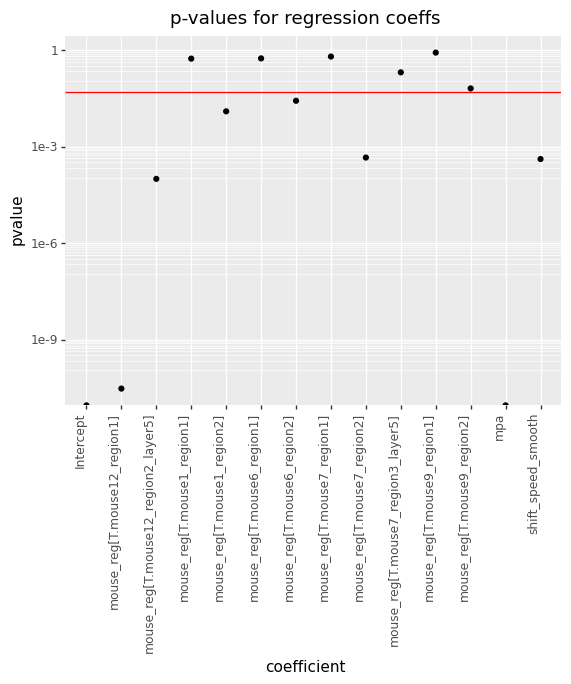

In [94]:
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from numpy.random import choice
from plotnine import element_text, geom_hline
from math import erf,sqrt

def phi_c(x):
    'complementary cumulative distribution function for the standard normal distribution'
    if len(x)>1:
        return np.array([ 1 - ((1.0 + erf(y / sqrt(2.0))) / 2.0) for y in x])
    else:
        return 1 - ((1.0 + erf(x / sqrt(2.0))) / 2.0)
    
    
filt_tab = res_tab[(res_tab.resp_type==1) & (res_tab.dc==.5)]
print('using {} data points'.format(len(filt_tab)))

scaler = StandardScaler().fit(filt_tab[['mpa','dff_resp',smoothcol]])
filt_tab.loc[:,['mpa','dff_resp',smoothcol]] = scaler.transform(filt_tab[['mpa','dff_resp',smoothcol]])
# lm = LinearRegression(normalize=True).fit(input_tab[:,:2], input_tab[:,-1])
# print('coefs: {}'.format( lm.coef_))
# print('score: {}'.format(lm.score(input_tab[:,:2], input_tab[:,-1])))
# lm = sm.OLS(input_tab[:,-1],input_tab[:,:2]).fit()

n_bootstrap = 200;
bootstrap_inds = [choice(len(filt_tab),len(filt_tab), replace=True) for x in range(n_bootstrap)]
param_list = [];
for train_ind in bootstrap_inds:
    lm = smf.rlm(formula = 'dff_resp~  mouse_reg + mpa + {}'.format(smoothcol), data=filt_tab.iloc[train_ind]).fit()
    param_list += [lm.params]
param_mean = np.array(param_list).mean(axis=0)
param_conf = np.array(param_list).std(axis=0)
param_tab = pd.DataFrame(columns=['param_mean','param_conf'])
param_tab['param_mean'] = param_mean
param_tab['param_conf'] = param_conf
#param_tab.set_index(param_list[0].index)

param_tab['param_name'] = param_list[0].index

plot = (ggplot(param_tab,aes(x = 'param_name',y='2*phi_c(np.abs(param_mean / param_conf))'))
              + geom_point()
          + theme(axis_text_x=element_text(rotation=90, hjust=1)  ) + scale_y_log10() 
        + ylab('pvalue') + xlab('coefficient') + ggtitle('p-values for regression coeffs') + geom_hline(yintercept=.05, color='r')
       )
plot.draw();

In [98]:
filt_tab = res_tab[(res_tab.resp_type==1) & (res_tab.dc==.5)]
print('using {} data points'.format(len(filt_tab)))

scaler = StandardScaler().fit(filt_tab[['mpa','dff_resp',smoothcol]])
filt_tab.loc[:,['mpa','dff_resp',smoothcol]] = scaler.transform(filt_tab[['mpa','dff_resp',smoothcol]])
lm = smf.ols(formula='dff_resp~  mouse_reg*(mpa + {})'.format(smoothcol),data=filt_tab).fit()
lm.summary()

using 20972 data points


C:\Users\bnste\anaconda3\envs\caiman\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               dff_resp   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     19.56
Date:                Fri, 05 Jun 2020   Prob (F-statistic):          2.64e-119
Time:                        16:14:07   Log-Likelihood:                -29421.
No. Observations:               20972   AIC:                         5.891e+04
Df Residuals:                   20936   BIC:                         5.920e+04
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
==========================================================================================================================
                                                             coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept                                                 -0.1213      0.038     -3.231      0.001      -0.195      -0.048
mouse_reg[T.mouse12_region1]                               0.1570      0.040      3.961      0.000       0.079       0.235
mouse_reg[T.mouse12_region2_layer5]                        0.0771      0.043      1.788      0.074      -0.007       0.162
mouse_reg[T.mouse1_region1]                                0.0975      0.089      1.095      0.273      -0.077       0.272
mouse_reg[T.mouse1_region2]                               -0.0663      0.107     -0.618      0.537      -0.277       0.144
mouse_reg[T.mouse6_region1]                                0.0068      0.110      0.062      0.951      -0.208       0.222
mouse_reg[T.mouse6_region2]                                0.1154      0.043      2.689      0.007       0.031       0.200
mouse_reg[T.mouse7_region1]                                0.2343      0.041      5.755      0.000       0.155       0.314
mouse_reg[T.mouse7_region2]                                0.0337      0.053      0.633      0.527      -0.071       0.138
mouse_reg[T.mouse7_region3_layer5]                         0.0112      0.048      0.232      0.817      -0.083       0.105
mouse_reg[T.mouse9_region1]                                0.0178      0.050      0.354      0.723      -0.081       0.116
mouse_reg[T.mouse9_region2]                                0.0849      0.047      1.790      0.073      -0.008       0.178
mpa                                                        0.0421      0.029      1.453      0.146      -0.015       0.099
mouse_reg[T.mouse12_region1]:mpa                           0.0957      0.032      3.015      0.003       0.033       0.158
mouse_reg[T.mouse12_region2_layer5]:mpa                    0.0744      0.037      2.010      0.044       0.002       0.147
mouse_reg[T.mouse1_region1]:mpa                           -0.0004      0.077     -0.006      0.995      -0.151       0.150
mouse_reg[T.mouse1_region2]:mpa                            0.2055      0.066      3.116      0.002       0.076       0.335
mouse_reg[T.mouse6_region1]:mpa                           -0.0905      0.104     -0.870      0.384      -0.294       0.113
mouse_reg[T.mouse6_region2]:mpa                            0.0390      0.034      1.134      0.257      -0.028       0.106
mouse_reg[T.mouse7_region1]:mpa                            0.1771      0.033      5.335      0.000       0.112       0.242
mouse_reg[T.mouse7_region2]:mpa                            0.0523      0.049      1.071      0.284      -0.043       0.148
mouse_reg[T.mouse7_region3_layer5]:mpa                     0.2170      0.042      5.198      0.000       0.135       0.299
mouse_re

In [106]:
for k,v in submodels.items():
    print(k,v)

mouse_reg shift_speed_smooth + mpa
mpa  mouse_reg*shift_speed_smooth
shift_speed_smooth dff_resp~  mouse_reg*mpa


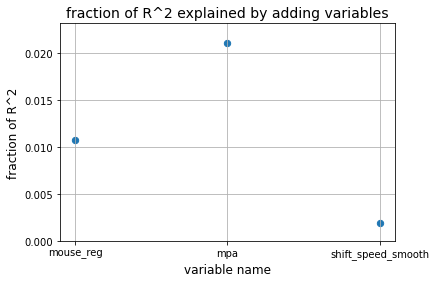

In [146]:
full_model = 'dff_resp~  mouse_reg*(mpa + shift_speed_smooth)'
submodels = {'mouse_reg':'dff_resp~shift_speed_smooth + mpa', 'mpa':'dff_resp~ mouse_reg*shift_speed_smooth', 'shift_speed_smooth':'dff_resp~  mouse_reg*mpa'}
delta_rsq = {}
filt_tab = res_tab[(res_tab.resp_type==1) & (res_tab.dc==.5)]
full_rsq = smf.ols(formula=full_model,data=filt_tab).fit().rsquared
for k,model in submodels.items():
    lm = smf.ols(formula=model,data=filt_tab).fit()
    delta_rsq[k] = full_rsq - lm.rsquared
    
plt.scatter(list(delta_rsq.keys()), list(delta_rsq.values()),s=40)
plt.xlabel('variable name', size=12)
plt.ylabel('fraction of R^2', size=12)
plt.title('fraction of R^2 explained by adding variables', size=14)
plt.ylim([0 ,1.1*max(delta_rsq.values())])
plt.plot()
plt.grid()

C:\Users\bnste\anaconda3\envs\caiman\lib\site-packages\plotnine\stats\smoothers.py:93: PlotnineWarning: Confidence intervals are not yet implementedfor RLM smoothing.
  warnings.warn("Confidence intervals are not yet implemented"
C:\Users\bnste\anaconda3\envs\caiman\lib\site-packages\plotnine\layer.py:452: PlotnineWarning: geom_point : Removed 54 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


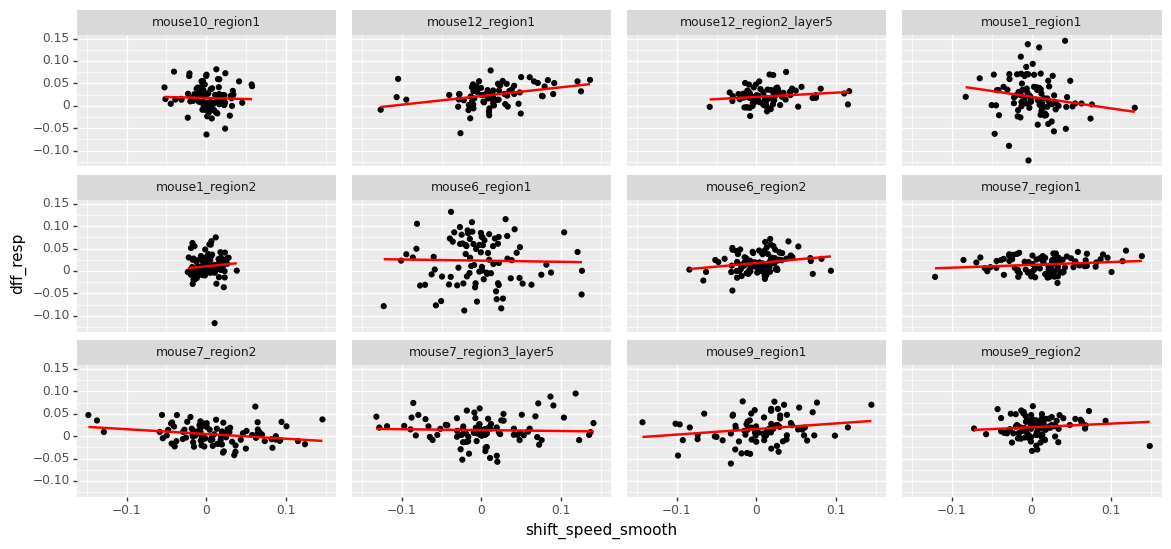

In [91]:
plot = (ggplot(res_tab[ (res_tab.resp_type==1) & (np.abs(res_tab.shift_speed_smooth) < .15) & (np.abs(res_tab.dff_resp) < .15)].groupby(['mouse_reg','trial','mov']).mean().reset_index(),aes(y='dff_resp',x='shift_speed_smooth'))
        +geom_point()
        + facet_wrap('~mouse_reg') + stat_smooth(method='rlm', color='r')
       )
fig=plot.draw()
fig.set_size_inches((14,6))

C:\Users\bnste\anaconda3\envs\caiman\lib\site-packages\plotnine\stats\smoothers.py:93: PlotnineWarning: Confidence intervals are not yet implementedfor RLM smoothing.
  warnings.warn("Confidence intervals are not yet implemented"
C:\Users\bnste\anaconda3\envs\caiman\lib\site-packages\plotnine\layer.py:452: PlotnineWarning: geom_point : Removed 54 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


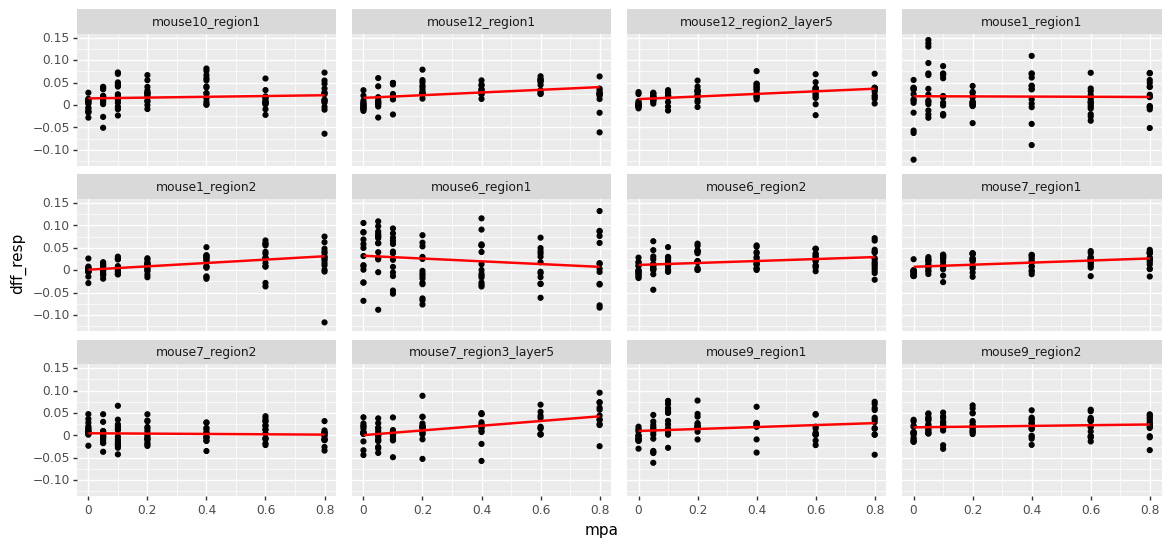

In [92]:
plot = (ggplot(res_tab[(res_tab.dc == .5) & (res_tab.resp_type==1) & (np.abs(res_tab.shift_speed_smooth) < .15) & (np.abs(res_tab.dff_resp) < .15)].groupby(['mouse_reg','trial','mov']).mean().reset_index(),aes(y='dff_resp',x='mpa'))
        +geom_point()
        + facet_wrap('~mouse_reg') + stat_smooth(method='rlm', color='r')
       )
fig=plot.draw()
fig.set_size_inches((14,6))

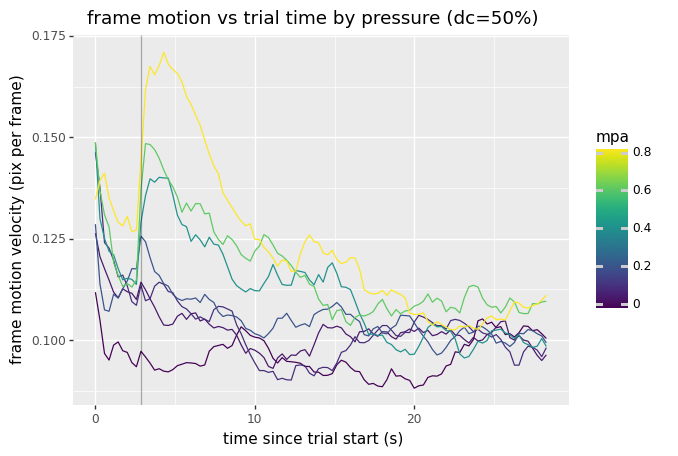

In [157]:
col = smoothcol
plottab = shift_tab[shift_tab.dc==.5].groupby(['frame','mpa'],as_index=False)[col].mean()
stim_frame=10
plot = (ggplot(plottab,aes(x='frame/fps',y=col, group='mpa', color='mpa'))
        + geom_line()
#         +geom_smooth(method='mavg', method_args={'window':4}, se=False)
        + geom_vline(xintercept=stim_frame / fps, alpha=.3)
        + xlab('time since trial start (s)')
        + ylab('frame motion velocity (pix per frame)')
        + ggtitle('frame motion vs trial time by pressure (dc=50%)')
       )

fig=plot.draw()

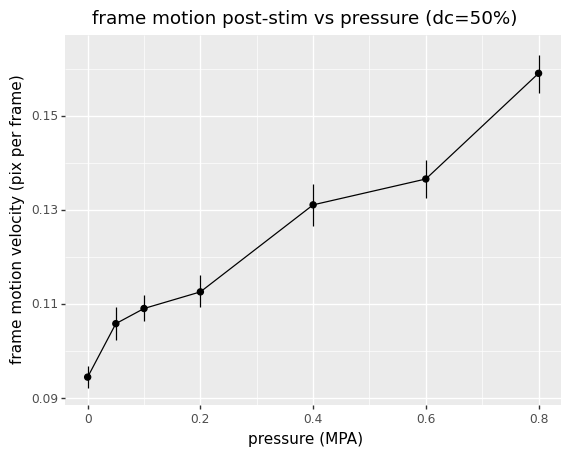

In [165]:
col = smoothcol
plottab = shift_tab[ (shift_tab.dc==.5) & (shift_tab.frame > stim_frame) & (shift_tab.frame <= stim_frame + fps*5)]
stim_frame=10
plot = (ggplot(plottab,aes(x='mpa',y=col))  + stat_summary() + geom_line(stat='summary')
        + xlab('pressure (MPA)')
        + ylab('frame motion velocity (pix per frame)')
        + ggtitle('frame motion post-stim vs pressure (dc=50%)')
       )

fig=plot.draw()

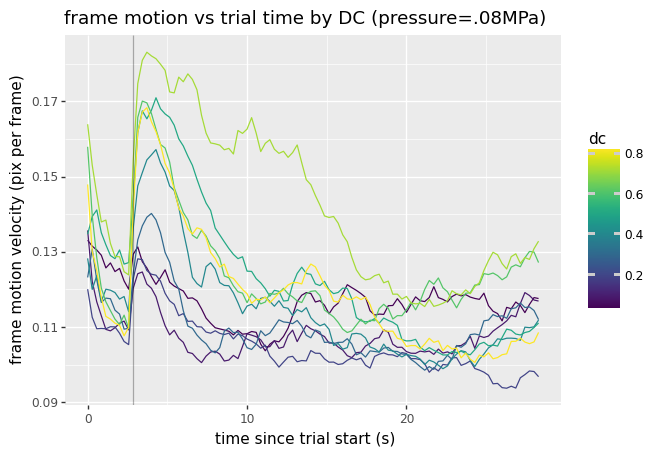

In [160]:
col = smoothcol
plottab = shift_tab[shift_tab.mpa==shift_tab.mpa.max()].groupby(['frame','dc'],as_index=False)[col].mean()
stim_frame=10
plot = (ggplot(plottab,aes(x='frame/fps',y=col, group='dc', color='dc'))  + geom_line()
#         + geom_smooth(method='mavg', method_args={'window':5}, se=False)
        + geom_vline(xintercept=stim_frame / fps, alpha=.3)
        + xlab('time since trial start (s)')
        + ylab('frame motion velocity (pix per frame)')
        + ggtitle('frame motion vs trial time by DC (pressure=.08MPa)')
       )

fig=plot.draw()

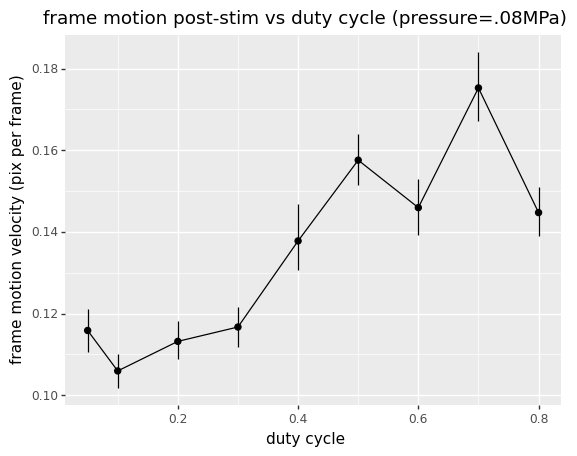

In [166]:
col = 'shift_speed'
plottab = shift_tab[(shift_tab.mpa==shift_tab.mpa.max()) & (shift_tab.frame > stim_frame) & (shift_tab.frame <= stim_frame + fps*5)]
stim_frame=10
plot = (ggplot(plottab,aes(x='dc',y=col))  + stat_summary() + geom_line(stat='summary')
        + xlab('duty cycle')
        + ylab('frame motion velocity (pix per frame)')
        + ggtitle('frame motion post-stim vs duty cycle (pressure=.08MPa)')
       )

fig=plot.draw()

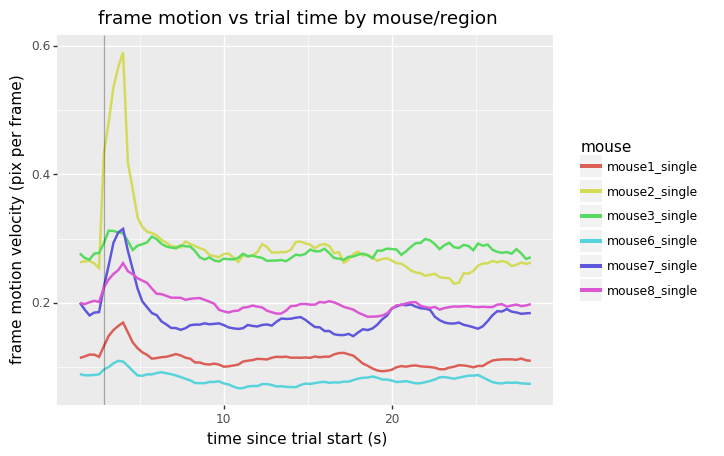

In [258]:
col = 'shift_speed'
meantab = shift_tab.groupby(['frame','mouse'],as_index=False)[col].mean()
stim_frame=10
plot = (ggplot(meantab,aes(x='frame/fps',y=col, group='mouse', color='mouse'))  + geom_smooth(method='mavg', method_args={'window':5},se=False)
        + geom_vline(xintercept=stim_frame / fps, alpha=.3)
        + xlab('time since trial start (s)')
        + ylab('frame motion velocity (pix per frame)')
        + ggtitle('frame motion vs trial time by mouse/region')
       )

fig=plot.draw()